# Intuitive Option Pricing

In this article, we'll use simulation and simple visualisations to build intuition around how different variables drive the price of an option.

Building this intuition is important because it helps you react quickly and make decisions without relying on complex pricing models. 

Let's get to it. 

## The value of a call option at expiration

A call option gives the holder the right to buy the underlying at the strike price on or before the expiration date.

That means that the value, $V_{call}$, of the call option at expiration, is described by a step-wise function in the price at expiry, $p_e$ and the strike, $s$:

$
V_{call} = 
\begin{cases} 
0 & p_e \leq s \\\ 
p_e – s & p_e > s 
\end{cases}
$

That just says that the option, at expiration, is:

- worthless if the price at expiration is less than or equal to the strike  
- worth something if the price at expiration is more than the strike

In precise terms, if the option expires “in the money” then it is worth the price at expiration less the strike. That’s simply because when the option expires in the money, you acquire the stock at the strike price and can immediately sell at the expiration price, pocketing the difference.

Here’s a visual example of the payoff function of a call option at expiry with a strike of 100:

In [140]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

library(tidyverse)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

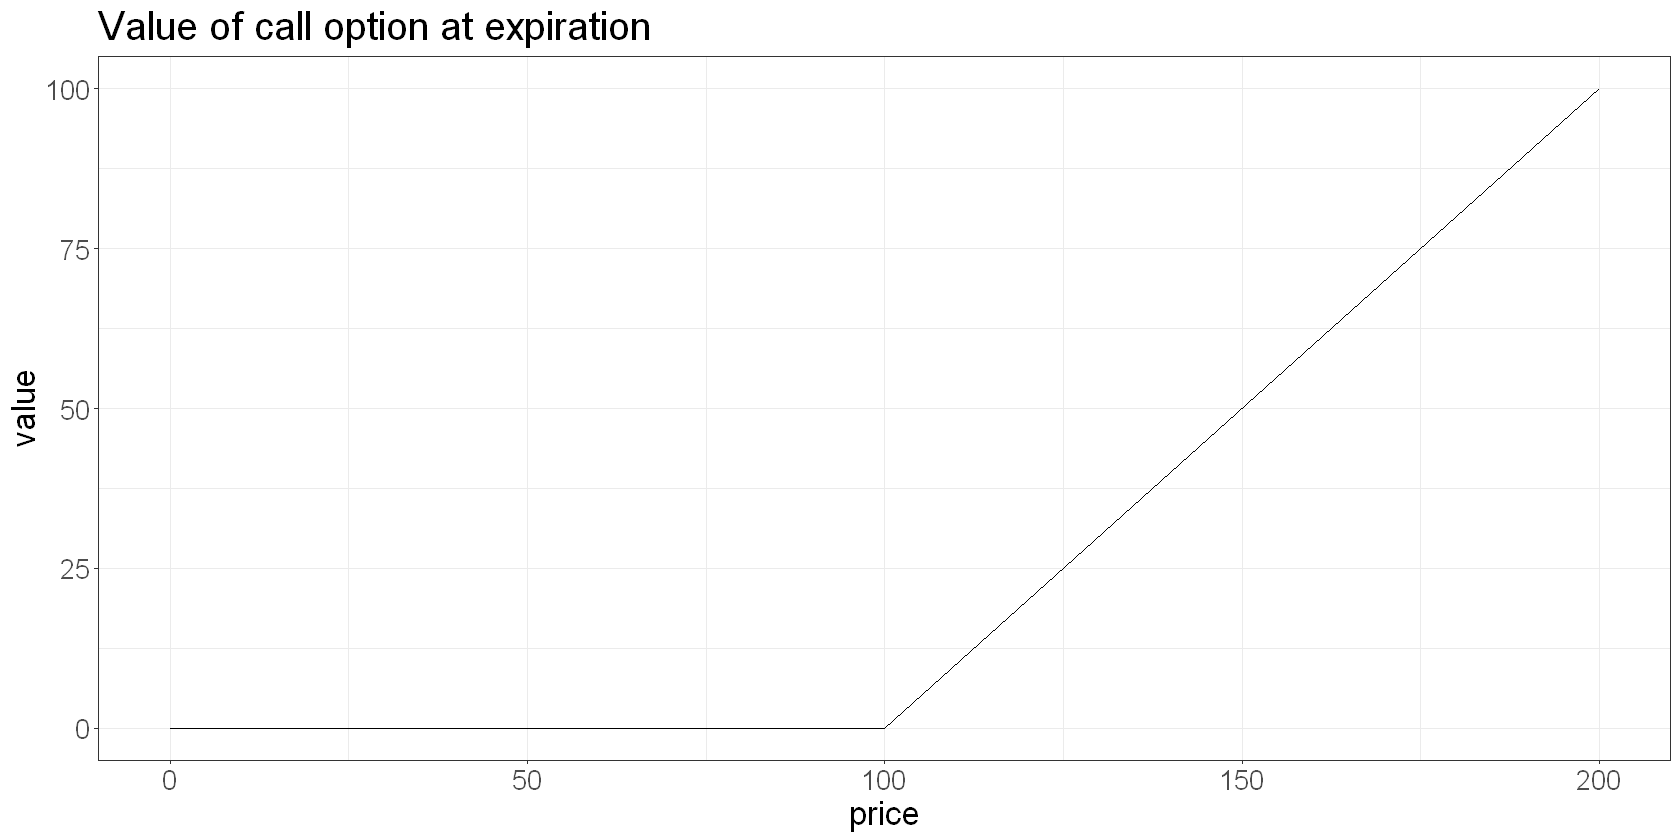

In [141]:
# "instrinsic value"
min_price <- 0
max_price <- 200
strike <- 100
call_payoffs <- tibble(price = c(min_price, strike, max_price)) %>%
  mutate(value = case_when(price < strike ~ 0, TRUE ~ price - strike))

call_payoffs %>%
  ggplot(aes(x = price, y = value)) +
  geom_line() +
  ggtitle('Value of call option at expiration')

## The value of a put option at expiration

A put option gives the holder the right to sell the underlying at the strike price on or before the expiration date.

That means that the value, $V_put$, of the put option at expiration, is also described by a step-wise function:

$
V_{put} = 
\begin{cases} 
s – p_e & p_e < s \\\ 
0 & p_e \geq s 
\end{cases}
$

That just says that the option, at expiration, is:

- worth something if the price at expiration is less than the strike
- worthless if the price at expiration is greater than or equal to the strike

In precise terms, if the option expires “in the money,” it’s worth the strike less the price at expiration. That’s simply because when the option expires in the money, you acquire a short position in the stock at the (high) strike price and can immediately buy it back at the (lower) expiration price, pocketing the difference.

Here’s a visual example of the payoff function of a call option at expiry with a strike of 100:

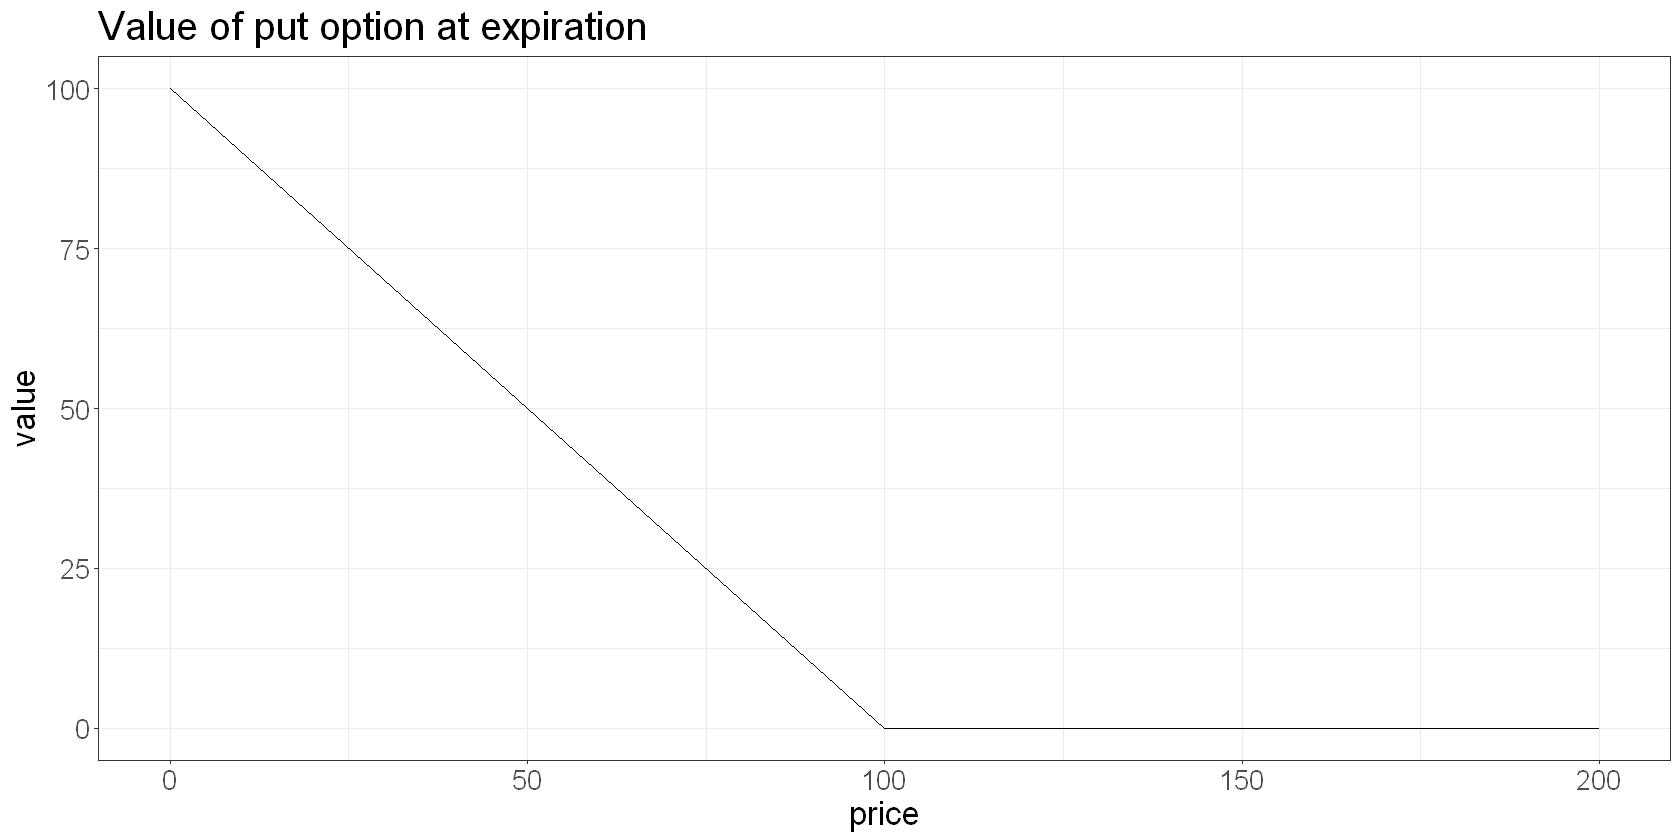

In [142]:
put_payoffs <- tibble(price = c(min_price, strike, max_price)) %>%
  mutate(value = case_when(price > strike ~ 0, TRUE ~ strike - price))

put_payoffs %>%
  ggplot(aes(x = price, y = value)) +
  geom_line() +
  ggtitle('Value of put option at expiration')

## Finger-in-the-air option pricing

So far so good. The value of an option at expiration is fairly intuitive – it’s either worth something or it isn’t, depending on the underlying’s price at expiration in relation to the strike.

What about the value of an option *prior* to its expiration?

If we ignore annoying things like interest rates and dividends, then the option’s value is related to just two fundamental properties:

- the possible values for the underlying at expiration
- the probability of the underlying closing at these values at expiration

In fact, the option’s expected value is simply the sum of these possible values weighted according to their probability of occurring.

Here’s a simple example to illustrate the point.

Say we play a game with only two outcomes: a coin toss. If heads comes up, we win $1.50. If tails comes up, we lose $1. The expected value of playing this game is the probability-weighted sum of the possible outcomes:

- 50% chance of winning $1.50
- 50% chance of losing $1.00

The expected value is $E = 0.5 * 1.5 + 0.5 * -1 = 0.25$

I’m sure you intuitively knew that playing this game many times would, on average, yield $0.25 per game. We have only two possible outcomes, and the probabilities associated with them are known.

But what about something more complex with a large number of possible outcomes?

Well, we do precisely the same thing. We take the possible outcomes, weight them by their probability of occurrence, and then sum those values. We just have a bit more work to do to understand those possible outcomes.

Here’s a visualisation to demonstrate.

- The blue line is the payoff function of a call option struck at 100. It shows the payoff associated with each possible expiry price between 80 and 120.
- The red line is the probability associated with each expiry price.

To calculate the expected value of the option, we multiply the blue line with the red line, and then sum the resulting set of numbers.

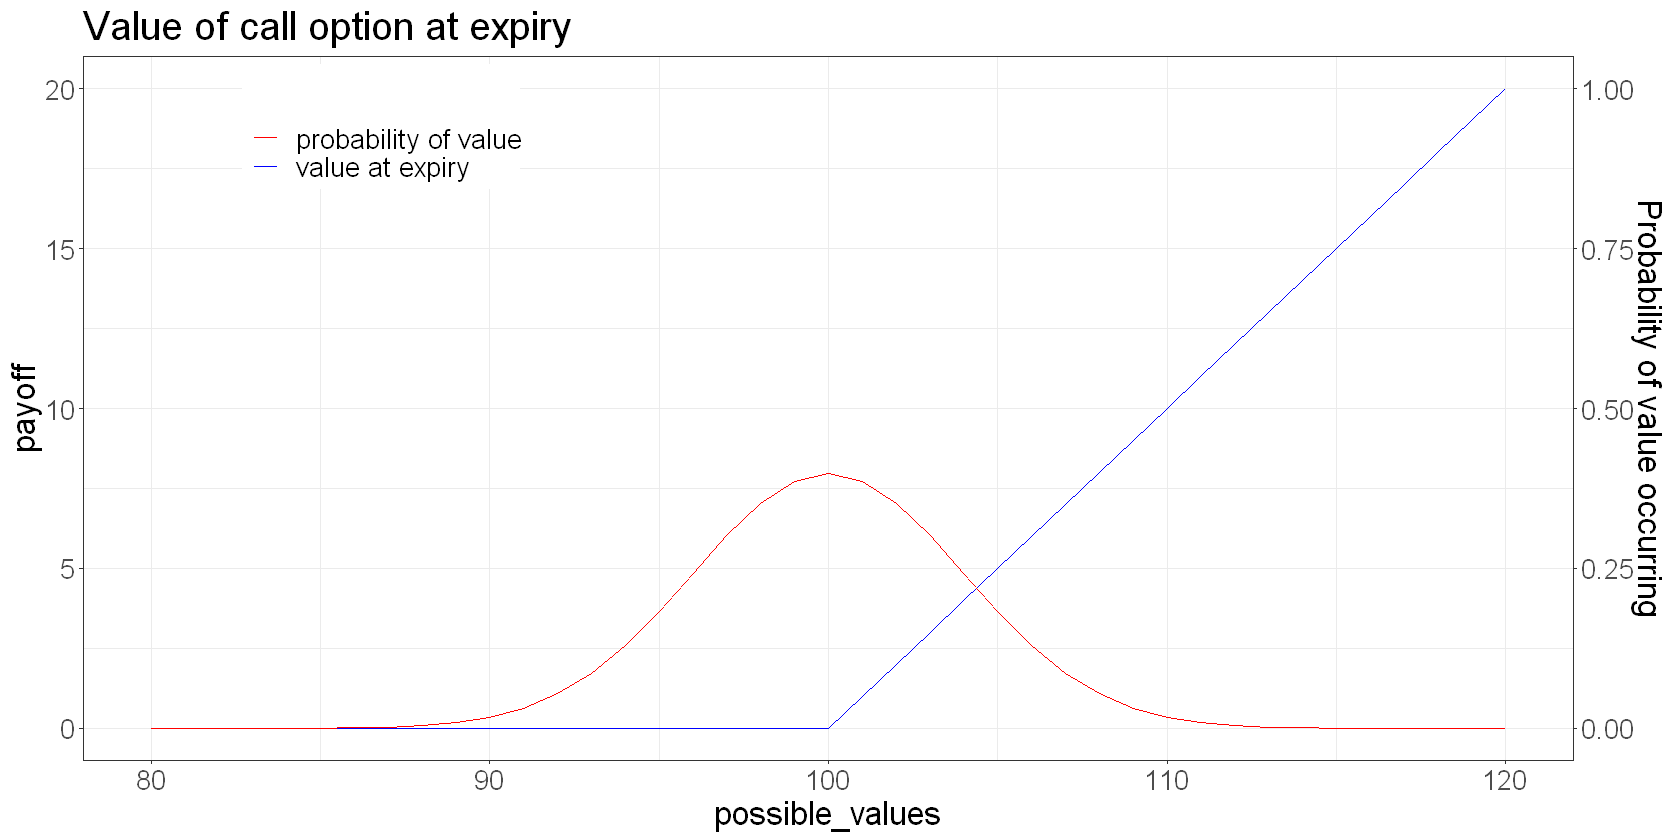

In [143]:
strike <- 100
payoff <- tibble(
  possible_values = 80:120,
  payoff = case_when(possible_values < strike ~ 0, TRUE ~ possible_values - strike),
  probability = dnorm(seq(-5, 5, length.out = length(possible_values)), mean = 0, sd = 1)
  )

payoff %>%
  ggplot(aes(x = possible_values, y = payoff)) +
  geom_line(aes(colour = 'value at expiry')) +
  geom_line(aes(y = probability*20, colour = 'probability of value')) +
  ggtitle('Value of call option at expiry') +
  labs(colour = "") +
  scale_y_continuous(sec.axis = sec_axis(~./20, name = "Probability of value occurring")) +
  scale_colour_manual(values = c('red', 'blue')) +
  theme(legend.position = c(0.2, 0.9))

The possible expiration values up to and including 100 contribute nothing to the expected value of the option, since we’re multiplying the red line by the blue line (which is zero at and below 100.)

In this particular example, a lot of probability mass is associated with possible expiration values around the strike (because the red line is high around the strike.) As the payoff increases (the blue line goes up), it has less probability associated with it.

Let’s plot the value of the probability-weighted payoffs to see what this looks like:

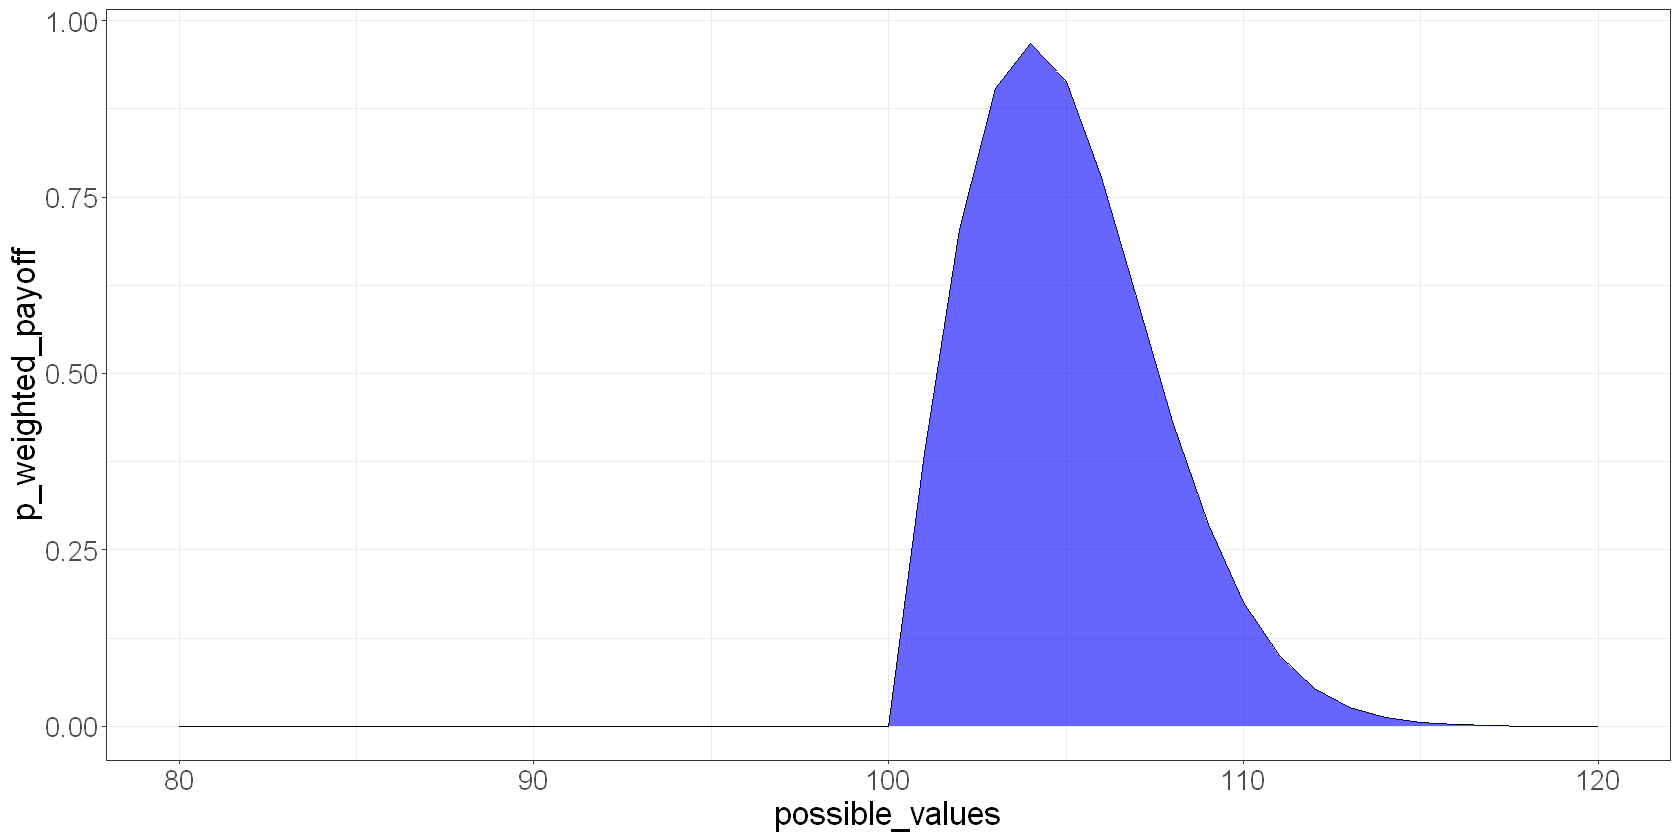

In [144]:
payoff <- payoff %>%
  mutate(p_weighted_payoff = payoff * probability) 

payoff %>%
  ggplot(aes(x = possible_values, y = p_weighted_payoff)) +
    geom_line() +
    geom_area(fill = 'blue', alpha=0.6)

This plot shows the contribution of each of the possible expiration values to the expected value of the option given the probability distribution we saw above.

To get the expected value of the option, we simply sum these probability-weighted payoffs, which is equivalent to the area under the curve above:

In [147]:
payoff %>%
  summarise(ev = sum(payoff * probability)) %>% 
  pull(ev) %>% 
  round(2)

[1] 6.35

The expected value of our option given the probability distribution of possible outcomes is about $6.40.

What if we had a different probability distribution?

Let’s say the distribution of possible expiration values was wider – that is, more of the probability mass was contained away from the centre of the distribution. Here’s what that might look like:

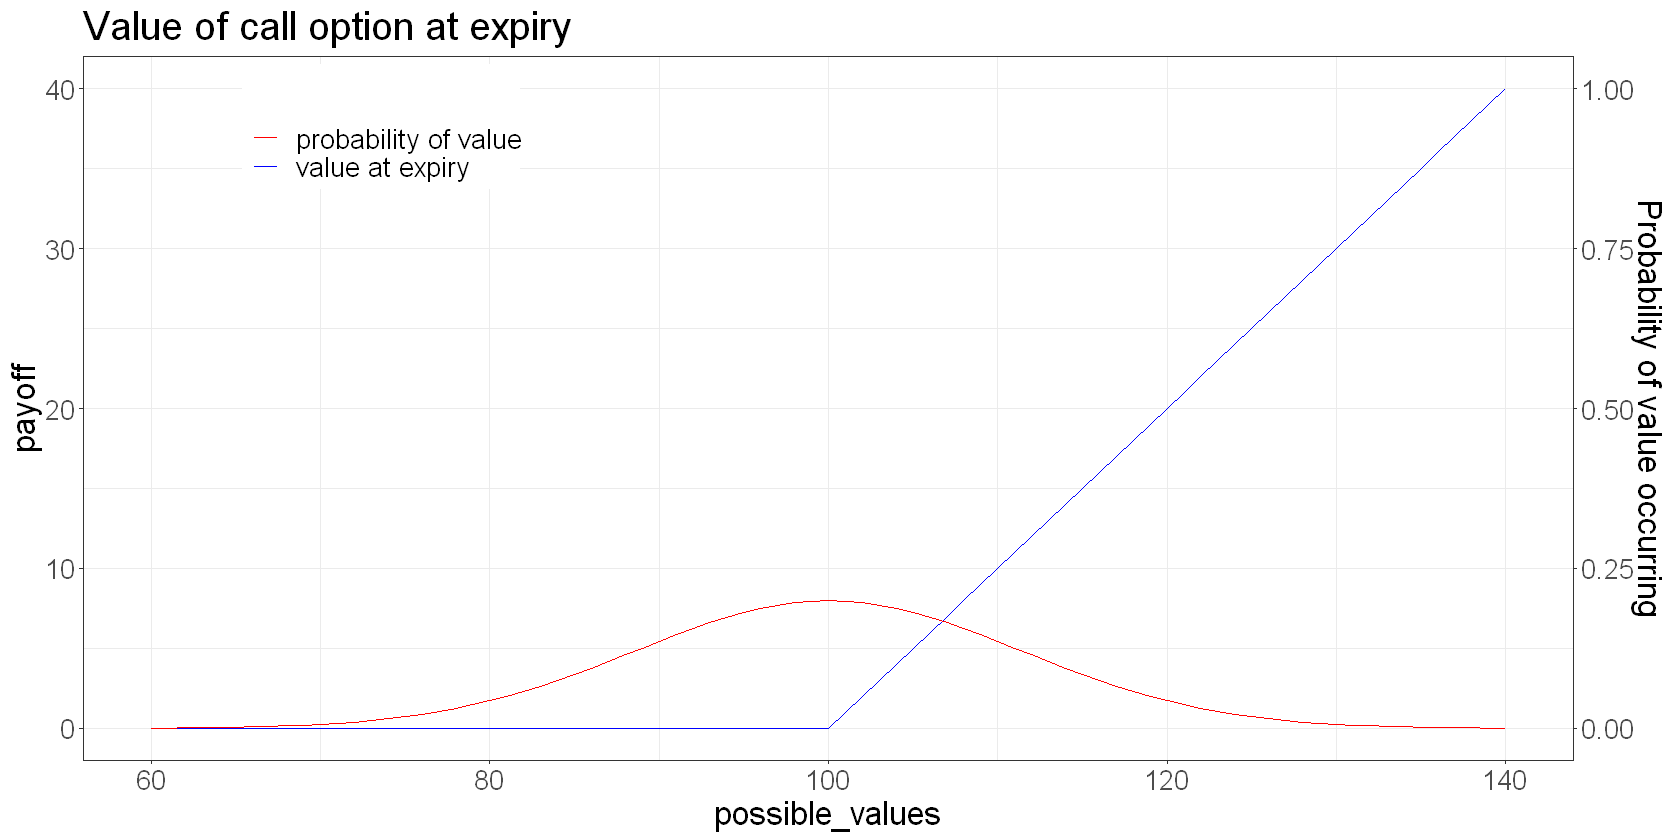

In [148]:
strike <- 100
payoff <- tibble(
  possible_values = 60:140,
  payoff = case_when(possible_values < strike ~ 0, TRUE ~ possible_values - strike),
  probability = dnorm(seq(-7, 7, length.out = length(possible_values)), mean = 0, sd = 2)
  )

payoff %>%
  ggplot(aes(x = possible_values, y = payoff)) +
  geom_line(aes(colour = 'value at expiry')) +
  geom_line(aes(y = probability*40, colour = 'probability of value')) +
  ggtitle('Value of call option at expiry') +
  labs(colour = "") +
  scale_y_continuous(sec.axis = sec_axis(~./40, name = "Probability of value occurring")) +
  scale_colour_manual(values = c('red', 'blue')) +
  theme(legend.position = c(0.2, 0.9))

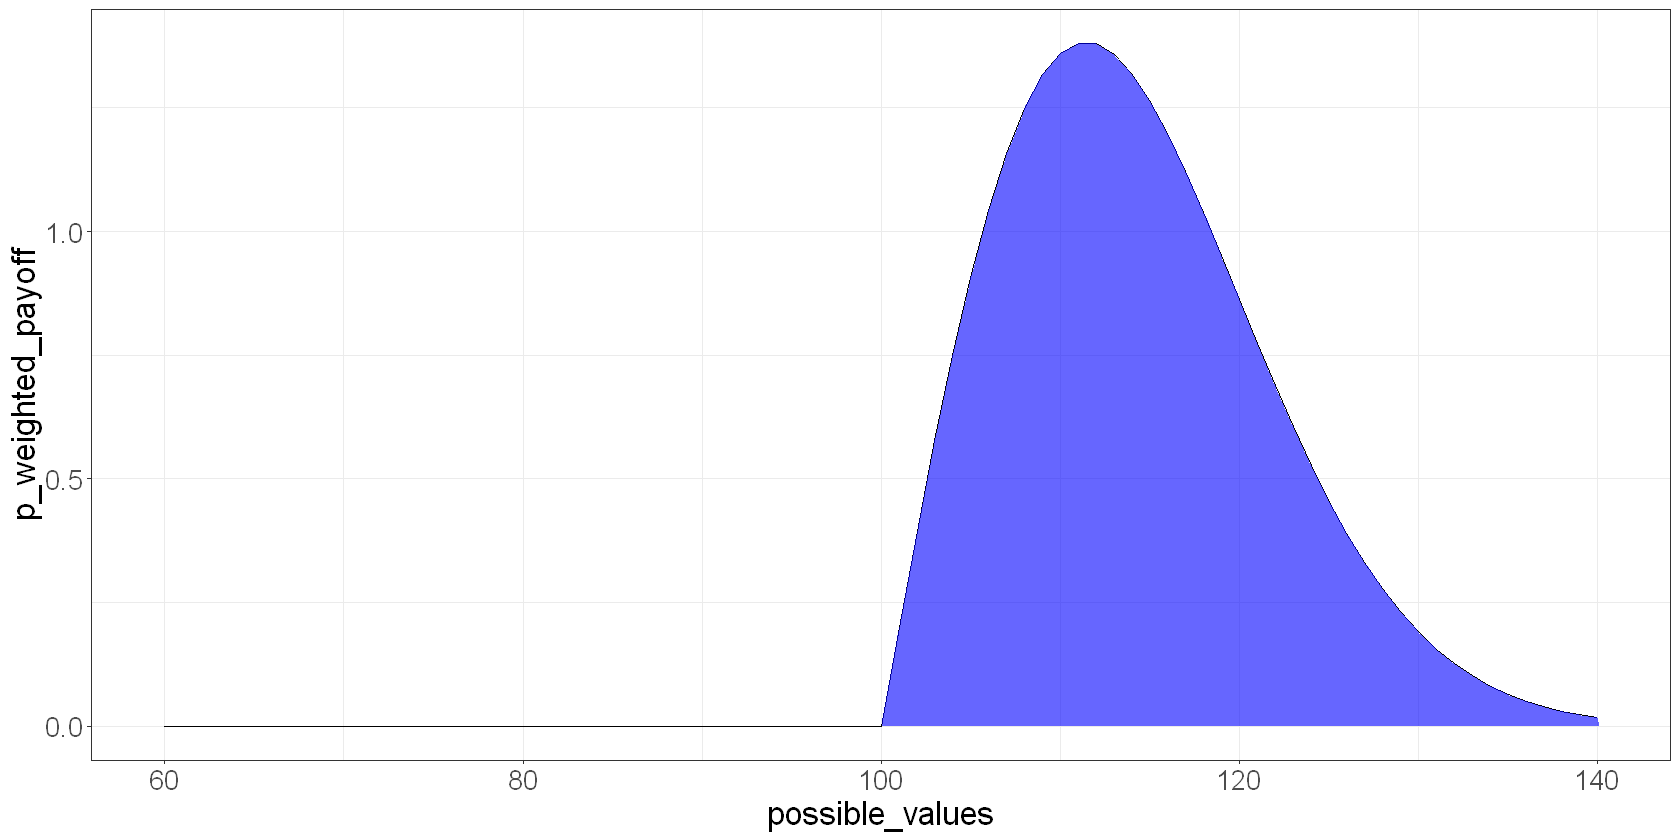

In [149]:
payoff <- payoff %>%
  mutate(p_weighted_payoff = payoff * probability) 

payoff %>%
  ggplot(aes(x = possible_values, y = p_weighted_payoff)) +
    geom_line() +
    geom_area(fill = 'blue', alpha=0.6)

In [150]:
payoff %>%
  summarise(ev = sum(payoff * probability))%>% 
  pull(ev) %>% 
  round(2)

[1] 25.99

In this case, we see that having more of the probability mass away from the mean of the distribution means that the larger payoffs contribute proportionately more to the expected value of the option.

> What would cause us to have a distribution like that?

Great question!

This would arise if there was a wider range of possible expiration prices. And volatility is the driver of the range of possible expiration prices. 

All else being equal, higher volatility results in a higher spread of possible prices $N$ time steps in the future. That makes intuitive sense – and we’ll see it in action shortly.

What about if we had a probability distribution that was right-shifted along the payoff function? That would look like this:

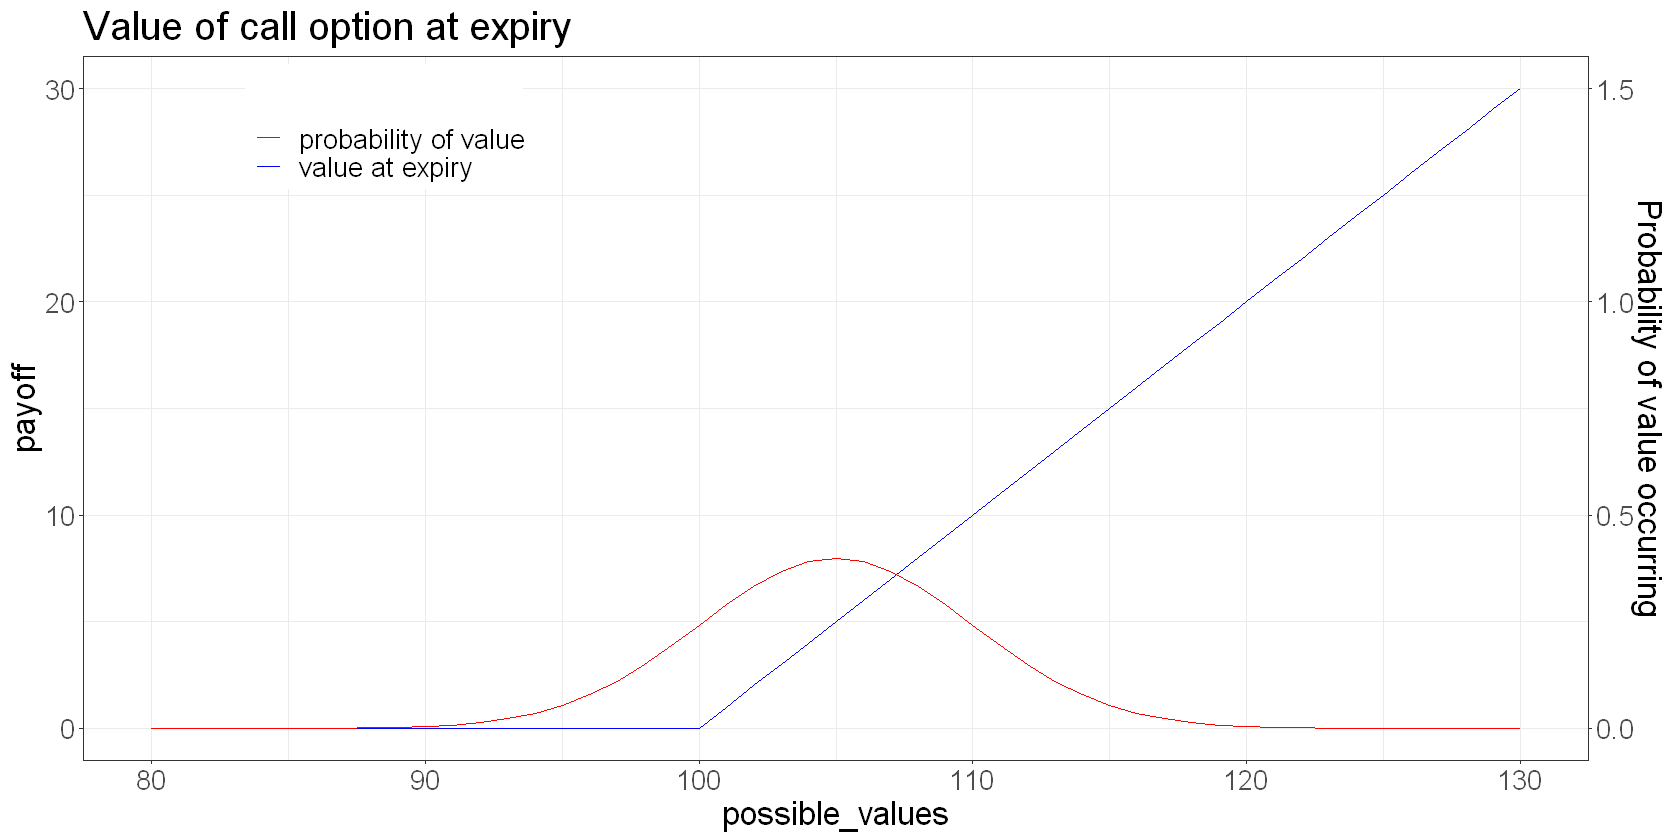

In [151]:
strike <- 100
payoff <- tibble(
  possible_values = 80:130,
  payoff = case_when(possible_values < strike ~ 0, TRUE ~ possible_values - strike),
  probability = dnorm(seq(-5, 5, length.out = length(possible_values)), mean = 0., sd = 1)
  )

payoff %>%
  ggplot(aes(x = possible_values, y = payoff)) +
  geom_line(aes(colour = 'value at expiry')) +
  geom_line(aes(y = probability*20, colour = 'probability of value')) +
  ggtitle('Value of call option at expiry') +
  labs(colour = "") +
  scale_y_continuous(sec.axis = sec_axis(~./20, name = "Probability of value occurring")) +
  scale_colour_manual(values = c('red', 'blue')) +
  theme(legend.position = c(0.2, 0.9))

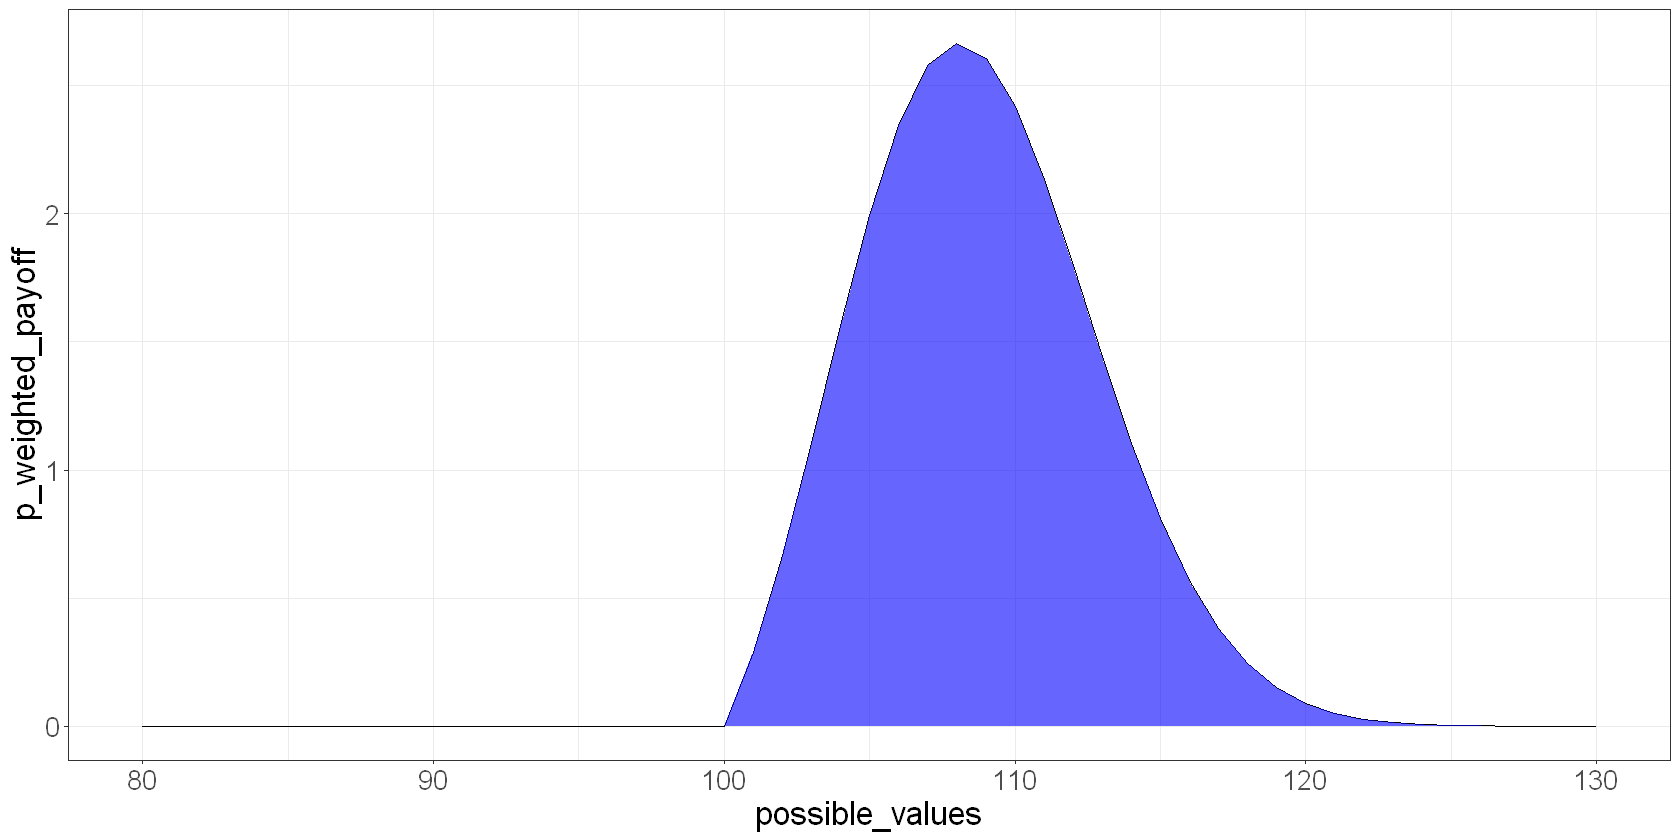

In [152]:
payoff <- payoff %>%
  mutate(p_weighted_payoff = payoff * probability) 

payoff %>%
  ggplot(aes(x = possible_values, y = p_weighted_payoff)) +
    geom_line() +
    geom_area(fill = 'blue', alpha=0.6)

In [153]:
payoff %>%
  summarise(ev = sum(payoff * probability)) %>% 
  pull(ev) %>% 
  round(2)

[1] 27.06

Again, this increases the expected value of the call option, this time because the higher payoff values have more probability mass assigned to them.

> But what would cause the probability distribution to be right-shifted like that?

That would occur if the current price was higher than the strike price.

This also makes intuitive sense – if the current price is higher than the strike price, then the range of possible outcomes at expiry is going to be skewed in the direction of higher payoff.

## So about that probability distribution…

The examples above are completely contrived – I literally made the probability distribution I wanted in order to make a point.

But you can see that the value of the option prior to expiration very clearly depends on that distribution of possible outcomes.

It follows that in order to price our option before expiry, we need some forecast of that distribution. That is, we need a view on the probabilities associated with each possible outcome.

> How might we arrive at such a view?

In situations like this, where we have a process that is heavily driven by uncertainty and randomness, it often pays to turn to simulation. The process looks like this:

- come up with a model of reality that captures the inherent uncertainty as best we can (or as we think appropriate)
- run the model many times
- calculate the probabilities associated with each possible outcome from the number of simulation runs that produced them

For instance, if we ran a simulation 1,000 times and 100 of those simulations produced a value of 10, then we’d infer the probability associated with the value 10 to be $100/1,000=0.1$, that is 10%.

There are of course difficulties associated with models of reality:

- the model is at best a representation of reality, an approximation
- we may not be able to accurately represent all of the things (variables) that impact the thing we want to simulate

Those limitations aside, models can still be useful. In particular in this case for getting a feel for the dynamics of option pricing.

### A model of the price process

Let’s keep things simple to start with. We’ll make some simplifying assumptions:

- the price of the security is a stochastic (random) process with no drift
- interest rates don’t exist
- dividends don’t exist

Think about the variables that drive the thing we’re trying to simulate – the terminal price of a security at some date in the future.

Fundamentally, those variables are (when we make our simplifying assumptions):
- the price of the security right now
- the time until the future date of interest (more time = larger range of outcomes, all else being equal)
- the volatility of the security (higher volatility = larger range of outcomes, all else being equal)

A widely accepted model of the price process is Geometric Brownian Motion (GBM). It has some nice properties that are consistent with stock prices:

- values can not be negative
- values will be log-normally distributed (a decent approximation for our purposes)

Here’s a GBM simulator. It takes a number of parameters:

- `nsim`: the number of simulations (that is, the number of price paths to simulate)
- `t`: the number of time steps to expiration
- `mu`: the mean of the stochastic process generating prices (we set this to zero in line with our assumptions)
- `sigma`: the annualised volatility of prices
- `S0`: the starting price at time  t0 
- `dt`: the length of a single time step (here dt is in units of years, consistent with our annualised volatility)

`epsilon` is a matrix containing the random draws from the generating process – one draw for each day for each simulation. We set this up as a matrix prior to running our simulator in order to leverage R’s ability to do vectorised operations. Sometimes in R we can replace loops with vectorised operations and reap dramatic increases in performance. This is what we’ve done here.

We simulate 1,000 possible price paths over 25 time steps given a starting price of 100, and a volatility of 10%. In the table below the code, you can see the first 10 values of the first 5 price path simulations:

In [154]:
gbm_sim <- function(nsim = 100, t = 25, mu = 0, sigma = 0.1, S0 = 100, dt = 1./365) {
  # matrix of random draws - one for each day for each simulation
  epsilon <- matrix(rnorm(t*nsim), ncol = nsim, nrow = t)  

  # get GBM paths
  gbm <- exp((mu - sigma * sigma / 2) * dt + sigma * epsilon * sqrt(dt))

  # convert to price paths
  gbm <- apply(rbind(rep(S0, nsim), gbm), 2, cumprod)

  return(gbm)
}

S0 <- 100
dt <- 1./365
sigma = 0.1
t <- 25
mu <- 0
nsim <- 1000
gbm <- gbm_sim(nsim = nsim, t = t, mu = mu, sigma = sigma, S0 = S0, dt = dt)

gbm[1:10, 1:5] %>%
  as.data.frame()

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100.00000,100.00000,100.00000,100.00000,100.00000
100.71094,99.32058,99.46561,99.29194,100.01378
100.57485,99.11775,99.95742,98.83342,100.10393
99.92930,98.75792,100.08205,98.08633,100.68302
99.64371,99.16727,100.43916,98.18958,100.03987
99.76616,99.84069,99.83963,98.04711,98.80163
100.12213,99.42458,99.52403,98.12683,98.87662
100.29585,99.09918,100.05517,97.43653,98.40223
99.94002,99.29733,100.94484,97.19316,98.39106


Let’s plot some of these price paths:

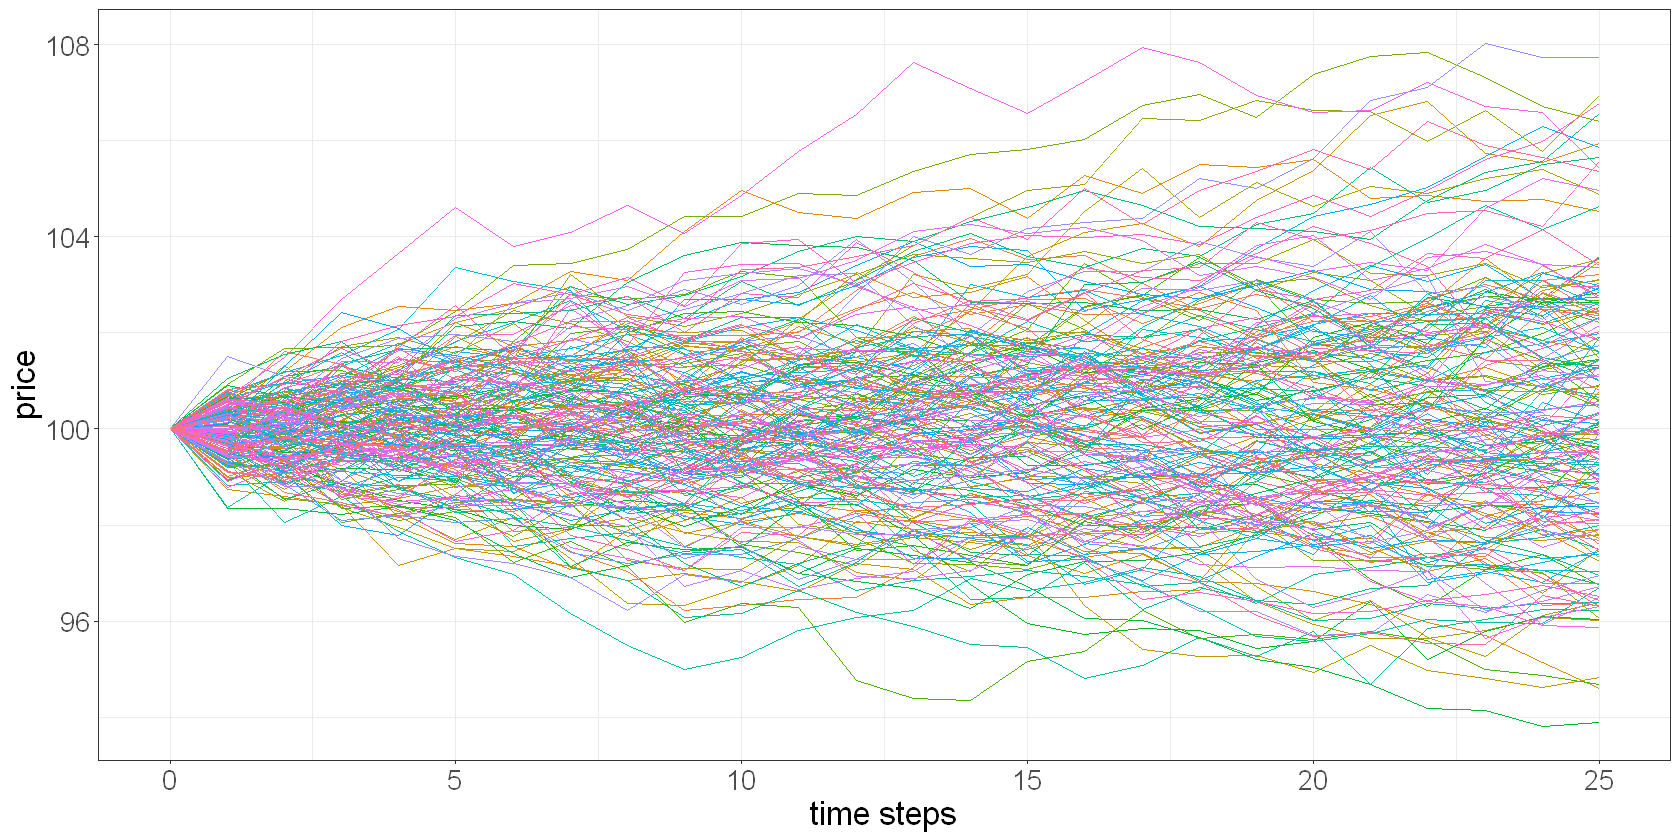

In [155]:
gbm_df <- as.data.frame(gbm) %>%
  mutate(ix = 0:(nrow(gbm)-1)) %>%
  pivot_longer(-ix, names_to = 'sim', values_to = 'price')

prices_plot <- gbm_df %>%
  filter(sim %in% paste0('V', c(1:200))) %>%
  ggplot(aes(x=ix, y=price, colour = sim)) +  
  geom_line() +
  xlab('time steps') +
  theme(legend.position = 'none')

prices_plot

We see:

- the range of terminal prices getting wider as time goes on (the “cone” of terminal prices expands with time)
- terminal prices concentrated around the starting price
- less frequent terminal prices far from the starting price

Most importantly, we’ve now got some values that we can work with. Specifically, we have 1,000 prices at expiration, 25 days after we started at a price of 100.

Let’s extract those terminal prices, look at their distribution (and ultimately derive a probability distribution). First, here’s a histogram of terminal prices:

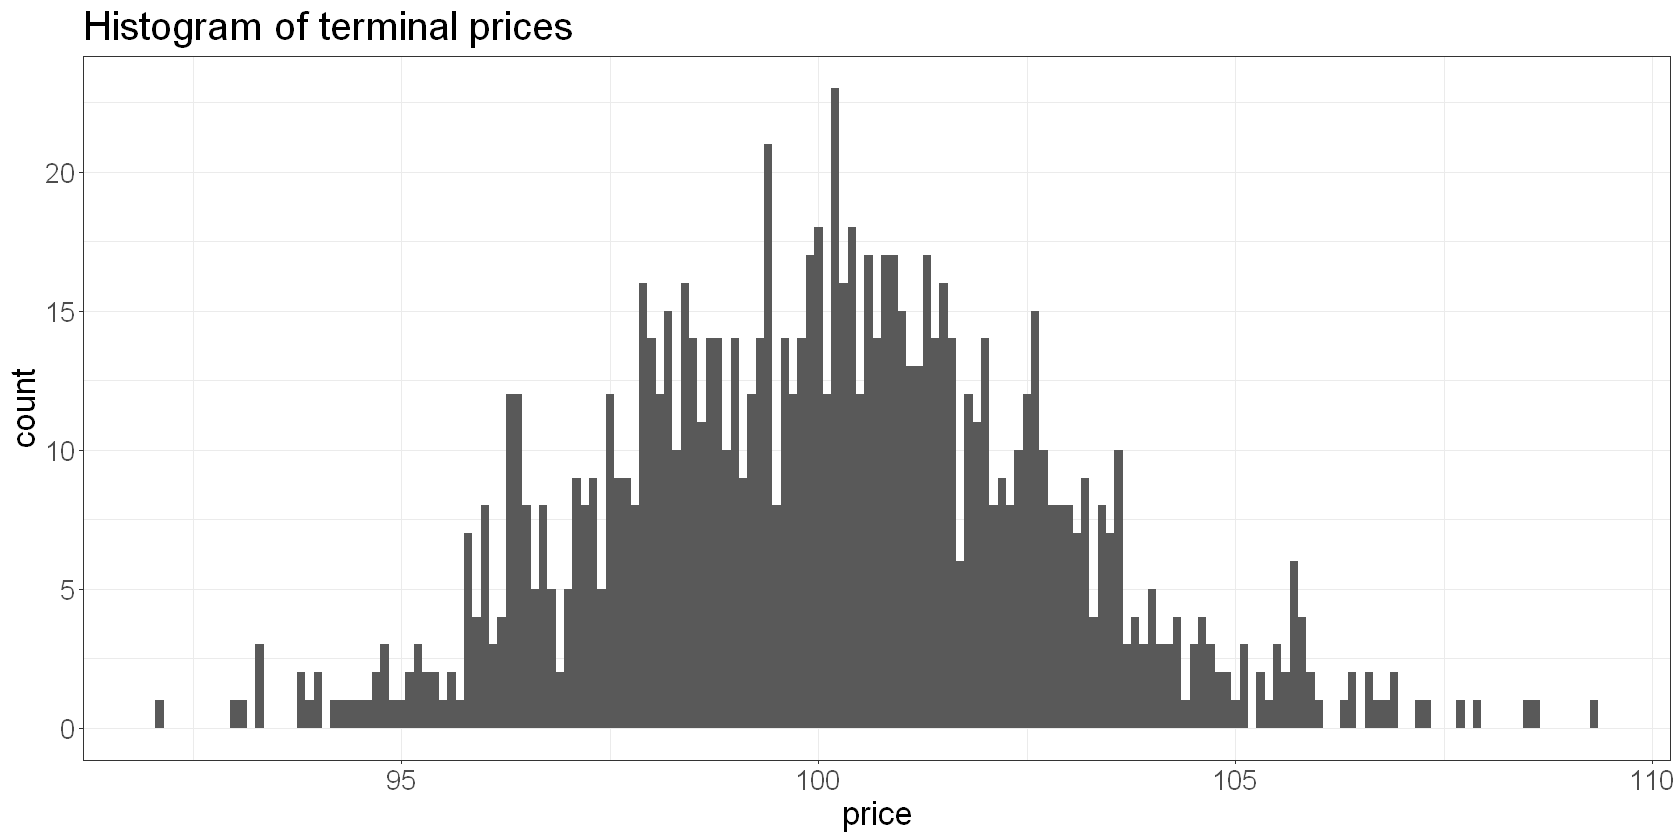

In [156]:
# distribution of terminal prices
gbm_df %>%
  filter(ix == max(gbm_df$ix)) %>%
  ggplot(aes(x = price)) +
    geom_histogram(binwidth = 0.1) +
    ggtitle('Histogram of terminal prices')

Next, a density plot.

A density plot is a representation of the distribution of a numeric variable – think of it as a smoothed version of the histogram. More specifically, it represents the probability per unit of something (in this case probability per unit of price), and is a good view of the relative probability of the values taken by the variable.

From the area under the density plot, we can derive probabilities of values falling within certain intvervals. More on that shortly.

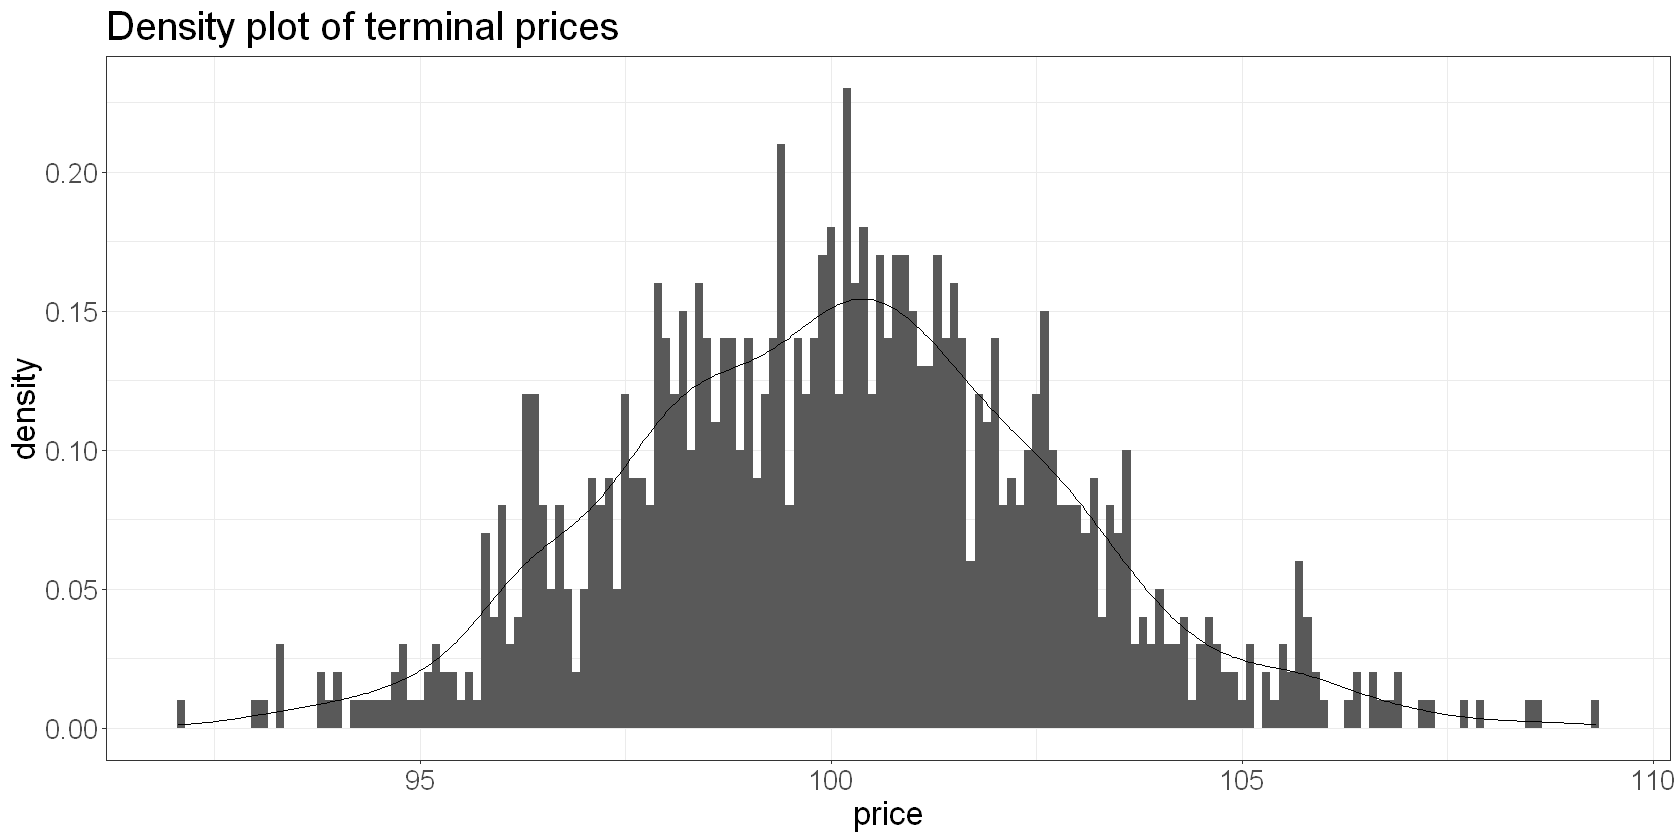

In [157]:
gbm_df %>%
  filter(ix == max(gbm_df$ix)) %>%
  ggplot(aes(x = price)) +
    geom_histogram(aes(y = ..density..), binwidth = 0.1) +
    geom_density() +
    ggtitle('Density plot of terminal prices')

The value of price at some time $t$ is also a log-normally distributed random variable. Its mean and standard deviation are functions of $t$.

In the next code block, I implemented the analytical solutions for the mean and standard deviation of price at time $t$ as the functions `terminal_ev` and `terminal_sd` (thanks chatGPT!).

Note in particular that the standard deviation of terminal prices – a proxy for the width of the distribution – depends on $t$ and the volatility of the generating process, `sigma`, thanks to the term `exp(sigma*sigma*t)`.

We can also derive these values empirically from our simulation results:

In [158]:
# S_t is a log-normally distributed random variable with expected value and standard deviation as functions of t:
terminal_ev <- function(S0, mu, t) {
  t_ev <- S0 * exp(mu * t)
  return(t_ev)
}

terminal_sd <- function(S0, mu, sigma, t, dt) {
  t_var <- S0*S0 * exp(2*mu*t) * (exp(sigma*sigma*t) - 1)
  t_sd <- sqrt(t_var) * sqrt(dt)  # note: take care to factor the time step!
  return(t_sd)
}

glue::glue("Terminal mean: {terminal_ev(S0, mu, max(gbm_df$ix))}")
glue::glue("Terminal sd: {terminal_sd(S0, mu, sigma, max(gbm_df$ix), dt)}")

Terminal mean: 100

Terminal sd: 2.78953728518147

In [159]:
# empirical mean and standard deviation of terminal prices
gbm_df %>%
  filter(ix == max(gbm_df$ix)) %>%
  summarise(mean = mean(price), sd = sd(price))

mean,sd
<dbl>,<dbl>
100.1262,2.639653


The fact that the standard deviation of price at time $t$ grows with $t$ means that the further the option is from expiration, the greater the range of possible outcomes.

It is perhaps easier to think about the distribution of terminal prices when we plot them alongside the actual price paths:

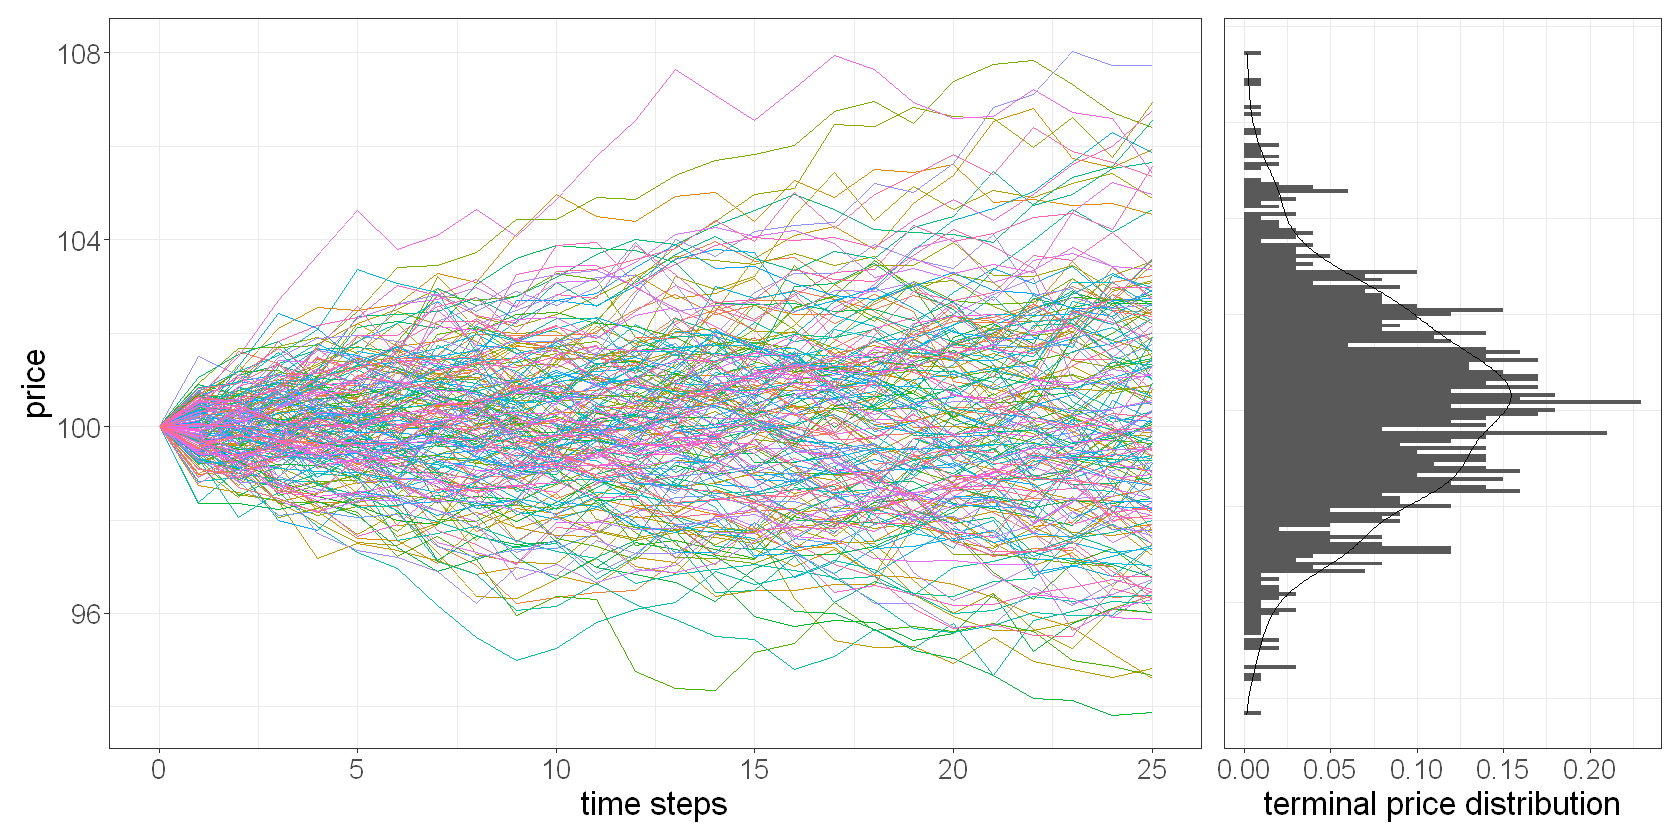

In [160]:
terminal_density_plot <- gbm_df %>%
  filter(ix == max(gbm_df$ix)) %>%
  ggplot(aes(x = price)) +
    geom_histogram(aes(y = ..density..), binwidth = 0.1) +
    geom_density() + 
    ylab('terminal price distribution') +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank()) +
    coord_flip()

prices_plot + terminal_density_plot + plot_layout(widths = c(1, 0.4))

Let’s see how that distribution changes if we simulate only 10 days until expiration:

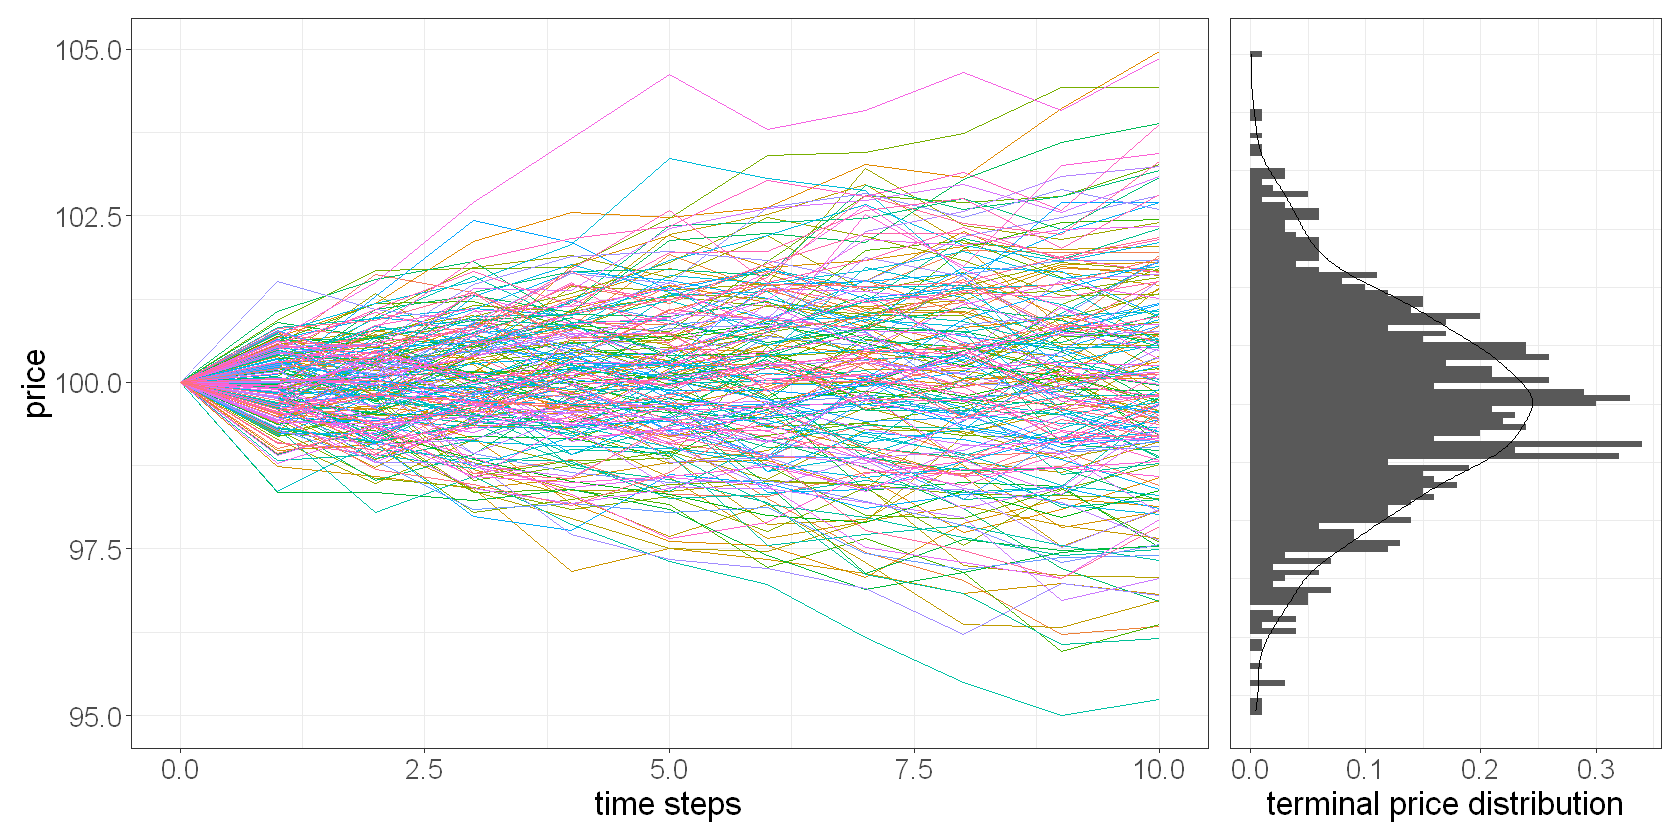

In [161]:
prices_plot_10 <- gbm_df %>%
  filter(ix <= 10) %>%
  filter(sim %in% paste0('V', c(1:200))) %>%
  ggplot(aes(x=ix, y=price, colour = sim)) +  
  geom_line() +
  xlab('time steps') +
  theme(legend.position = 'none')

terminal_density_plot_10 <- gbm_df %>%
  filter(ix == 10) %>%
  ggplot(aes(x = price)) +
    geom_histogram(aes(y = ..density..), binwidth = 0.1) +
    geom_density() + 
    ylab('terminal price distribution') +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank()) +
    coord_flip()

prices_plot_10 + terminal_density_plot_10 + plot_layout(widths = c(1., 0.4))

The distribution of the 10-day terminal prices is narrower – there’s less scope for price paths to spread out, all else being equal.

Let’s see what this looks like for for various expiration times:

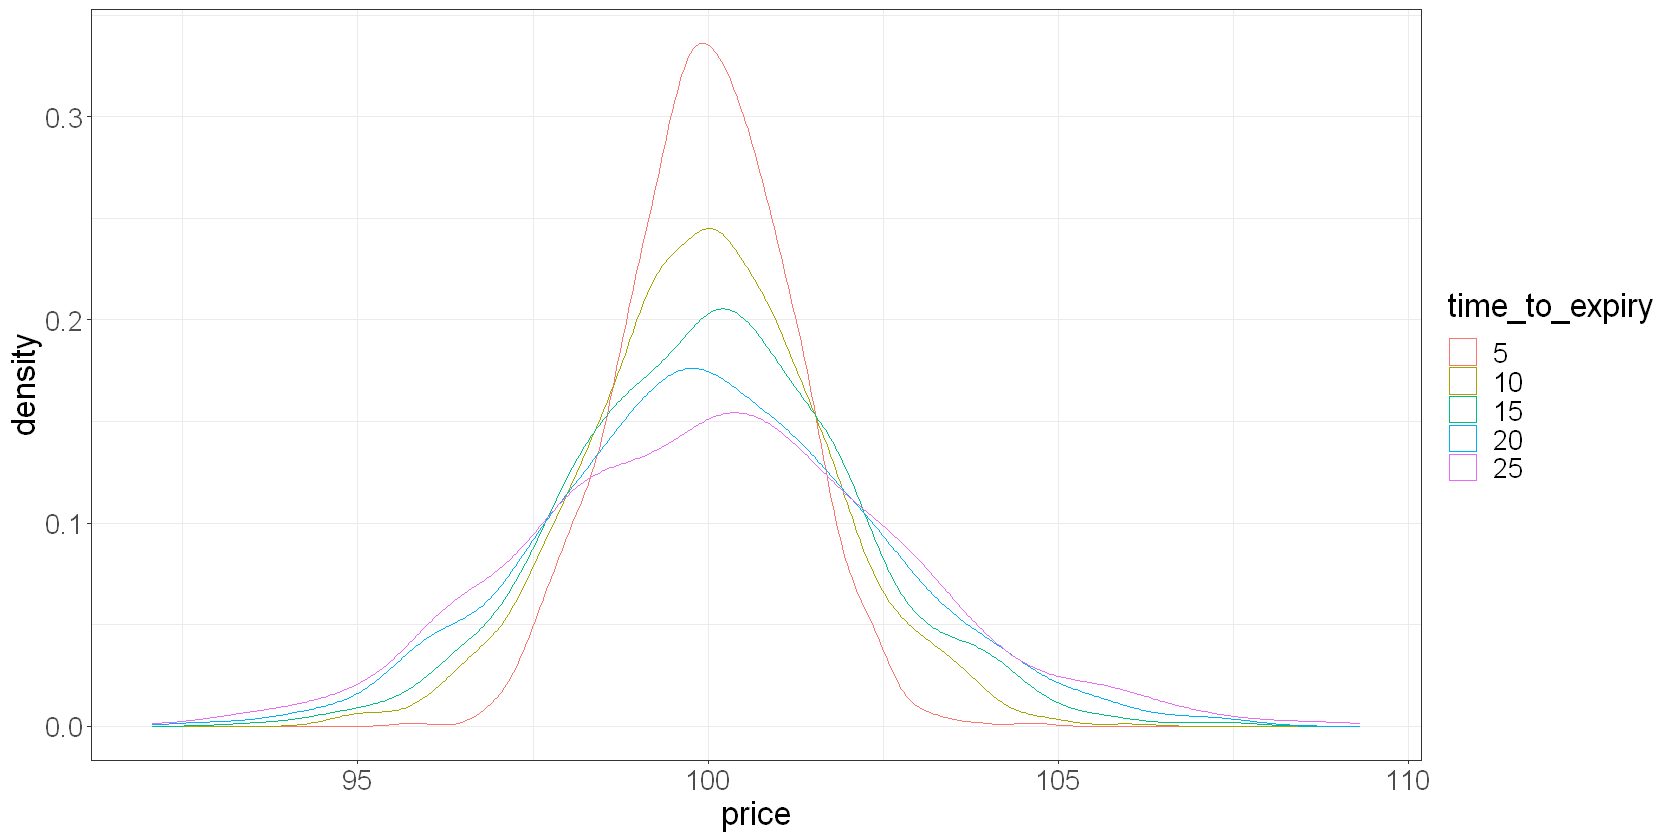

In [162]:
gbm_df %>%
  filter(ix %in% seq(5, 25, 5)) %>%
  mutate(time_to_expiry = factor(ix)) %>%
  ggplot(aes(x = price)) +
    geom_density(aes(colour = time_to_expiry))

You can clearly see the effect of increasing time to expiry: the distribution of possible terminal prices gets wider.

> OK that’s all very interesting….but what does that mean for actually pricing these things?

Great question. Let’s explore that next.

## Empirical option pricing

We know that the distribution of possible terminal prices is the key determinant of the expected value of an option.

We also know that the higher the current price in relation to the strike price, the more (less) valuable the call (put) option, because of the impact this has on shifting the distribution of possible outcomes.

We’ve now got an intuitive sense that all else being equal:

- The further out from expiry, the greater the range of possible terminal prices
- The greater the volatility, the greater the range of possible terminal prices

Next, we’re going to quantify that intuition by estimating the distribution of possible outcomes, and then using it to weight the payoff function. Remember, the expected value of our option is the probability-weighted sum of payoffs given simulated price paths.

There are two ways we can do this:

- Create a probability function from the simulated distribution of terminal prices
- Create a probability function from the density of the simulated distribution of terminal prices

The latter is easier to understand because it results in a smooth function that exists at every possible terminal price. The former requires a step-wise approach where we set up increments from one terminal price to the next.

In both cases, to calculate the expected value of the option, simply sum up the payoffs weighted by their probability.

Given enough simulations, the two approaches should converge. You can see them both in the next code block, but going forward we’ll use the density approach.

In [164]:
# payoff - call option
min_price <- min(gbm_df$price) - 0.15*min(gbm_df$price)
max_price <- max(gbm_df$price) + 0.15*max(gbm_df$price)
strike <- 100

# 1. using empirical data directly

# probability function from distribution of terminal prices
P <- gbm_df %>%
  filter(ix == max(gbm_df$ix)) %>%
  select(price) %>%
  pull() %>%
  ecdf()

# dataframe of payoffs and probabilities
E_call_payoffs <- tibble(price = seq(min_price, max_price, length.out = 1000)) %>%
  mutate(value = case_when(price < strike ~ 0, TRUE ~ price - strike), 
         cum_prob = P(price), 
         inc_prob = c(NA, diff(cum_prob)))

# option price given simulated terminal prices
E_exp_value <- E_call_payoffs %>%
  summarise(ev = sum(value * inc_prob, na.rm = TRUE)) %>% 
  pull(ev) %>% 
  round(2)

# 2. using density function estimated from empirical data (useful as it gives a continuous estimate)

# density function from distribution of terminal prices
D <- gbm_df %>%
  filter(ix == max(gbm_df$ix)) %>%
  select(price) %>%
  pull() %>%
  density()

# dataframe of payoffs and probabilities 
D_call_payoffs <- tibble(price = D$x, density = D$y/sum(D$y)) %>%
   mutate(value = case_when(price < strike ~ 0, TRUE ~ price - strike))

# option price given simulated terminal prices 
D_exp_value <- D_call_payoffs %>%
   summarise(ev = sum(density * value)) %>% 
  pull(ev) %>% 
  round(2)

print("Expected value estimated using empirical data directly:")
E_exp_value
print("Expected value estimated using a density function derived from the empirical data:")
D_exp_value

[1] "Expected value estimated using empirical data directly:"


[1] 1.12

[1] "Expected value estimated using a density function derived from the empirical data:"


[1] 1.14

Here’s a visualisation that shows each of the steps we just performed:

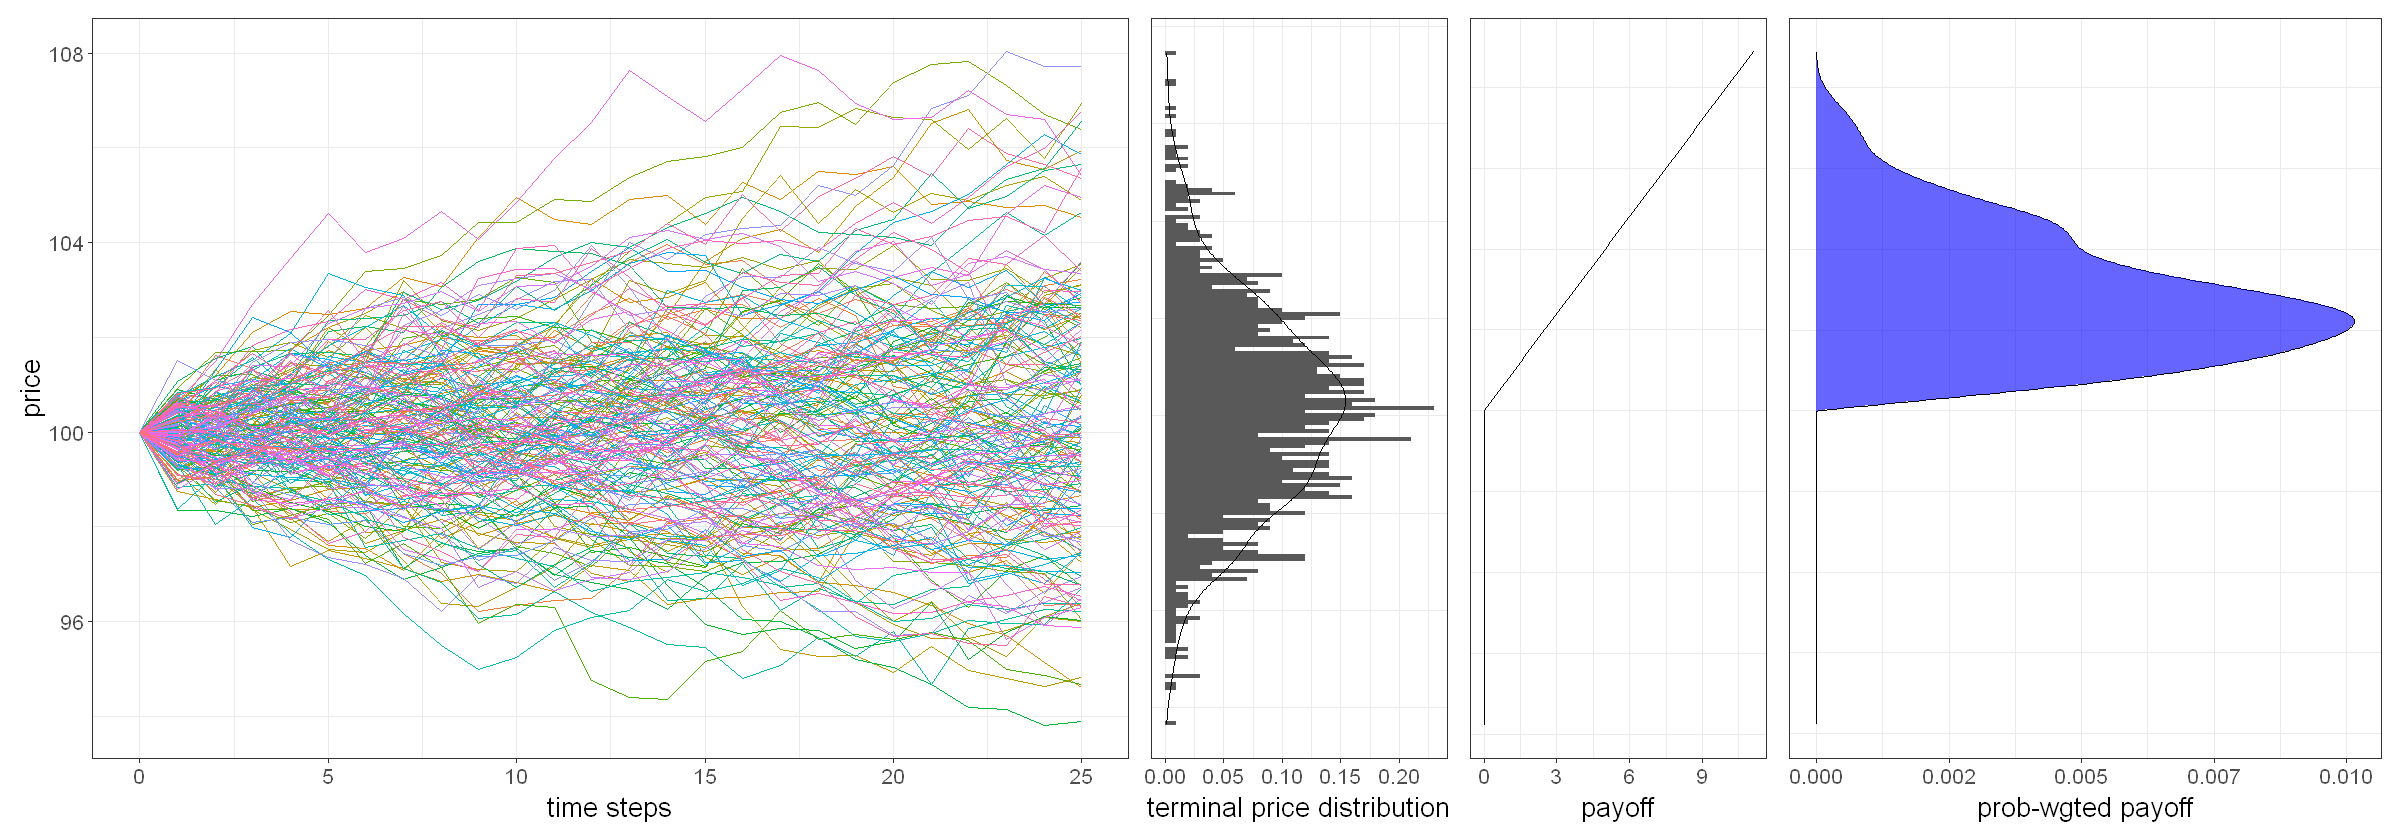

In [165]:
# we need a bigger chart
options(repr.plot.width = 20, repr.plot.height=7)
theme_update(text = element_text(size = 16))

payoff_plot <- D_call_payoffs %>%
  ggplot(aes(x = value, y = price)) +
  geom_line() +
  xlab('payoff') +
  theme(axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())

prob_weighted_payoff_plot <- D_call_payoffs %>%
  mutate(prob_weighted_payoff = value * density) %>%
  ggplot(aes(x = price, y = prob_weighted_payoff)) +
    geom_line() +
    geom_area(fill = 'blue', alpha = 0.6) +
    ylab('prob-wgted payoff') +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank()) +
    scale_y_continuous(labels=function(x){sprintf("%.3f", x)}) +
    coord_flip()

prices_plot + terminal_density_plot + payoff_plot + prob_weighted_payoff_plot + plot_layout(widths = c(1.4, 0.4, 0.4, 0.8))

- The first plot shows the simulated price paths.
- The second plot shows the distribution of simulated terminal prices
- The third plot shows the payoff function of the option (which is a fixed feature of the options contract)
- The final plot shows the probability-weighted payoff function

The expected value of the option is equal to the blue shaded area in the final plot – the sum of all the probability-weighted payoffs.

## Visualising the main intuitive drivers of option pricing

Let’s finish with a quick illustration of why this is a useful mental model for understanding the value of an option.

The intuitively obvious factors that affect the value of an option are:

- How intrinsically valuable is it?
- How uncertain is the attractiveness of the option?
- How long does the option last?

We’re going to use the visualisation we’ve developed here to illustrate these points. It's useful for developing intuition around:

- The random process that drives stock prices
- What that means for the distribution of those prices at the expiration date

First, let’s make functions for doing all the things we did above, and then wrap our visualisation in its own function so we can easily reuse it:

In [166]:
make_long_gbm_df <- function(gbm_matrix) {
  long_df <- as.data.frame(gbm_matrix) %>%
    mutate(ix = 0:(nrow(gbm_matrix)-1)) %>%
    pivot_longer(-ix, names_to = 'sim', values_to = 'price')

  return(long_df)
}

prices_plot <- function(gbm_long_df) {
  p <- gbm_long_df %>%
    filter(sim %in% paste0('V', c(1:200))) %>%
    ggplot(aes(x=ix, y=price, colour = sim)) +  
      geom_line() +
      xlab('time steps') +
      theme(legend.position = 'none')

  return(p)
}

terminal_density_plot <- function(gbm_long_df) {
  p <- gbm_long_df %>% 
    filter(ix == max(gbm_long_df$ix)) %>%
      ggplot(aes(x = price)) +
        geom_histogram(aes(y = ..density..), binwidth = 0.1) +
        geom_density() + 
        ylab('terminal price distribution') +
        theme(axis.title.y = element_blank(),
              axis.text.y = element_blank(),
              axis.ticks.y = element_blank()) +
        coord_flip()

  return(p)
}

call_payoff_profile_density <- function(gbm_long_df, time_to_expriy, strike) {
  "given a (long) dataframe of simulated price paths, a time to expiry and a strike, return a dataframe of terminal prices, their density-derived probability, and their call option payoff values"
  D <- gbm_long_df %>%
    filter(ix == time_to_expriy) %>%
    select(price) %>%
    pull() %>%
    density()

  # dataframe of payoffs and probabilities 
  payoff_profile <- tibble(price = D$x, density = D$y/sum(D$y)) %>%
     mutate(value = case_when(price < strike ~ 0, TRUE ~ price - strike))

  return(payoff_profile)
}

put_payoff_profile <- function(gbm_long_df, time_to_expriy, strike) {
  "given a (long) dataframe of simulated price paths, a time to expiry and a strike, return a dataframe of terminal prices, their density-derived probability, and their put option payoff values"
  D <- gbm_long_df %>%
    filter(ix == time_to_expriy) %>%
    select(price) %>%
    pull() %>%
    density()

  # dataframe of payoffs and probabilities 
  payoff_profile <- tibble(price = D$x, density = D$y/sum(D$y)) %>%
     mutate(value = case_when(price > strike ~ 0, TRUE ~ strike - price))

  return(payoff_profile)
}

payoff_plot <- function(payoff_profile) {
  p <- payoff_profile %>%
    ggplot(aes(x = value, y = price)) +
    geom_line() +
    xlab('payoff') +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank())

  return(p)
} 

prob_weighted_payoff_plot <- function(payoff_profile) {
  p <- payoff_profile %>%
    mutate(prob_weighted_payoff = value * density) %>%
    ggplot(aes(x = price, y = prob_weighted_payoff)) +
      geom_line() +
      geom_area(fill = 'blue', alpha = 0.6) +
      ylab('prob-wgted payoff') +
      theme(axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank()) +
      scale_y_continuous(labels=function(x){sprintf("%.3f", x)}) +
      coord_flip()

  return(p)
}

option_valuation_plot <- function(gbm_matrix, strike, time_to_expiry, option_type = 'call') {
  stopifnot(option_type %in% c('call', 'put'))

  gbm_df <- make_long_gbm_df(gbm_matrix)

  pr_plot <- prices_plot(gbm_df) 
  td_plot <- terminal_density_plot(gbm_df)

  if(option_type == 'call') {
    payoff_profile <- call_payoff_profile_density(gbm_df, time_to_expriy = time_to_expiry, strike = strike)
  } else {
    payoff_profile <- put_payoff_profile_density(gbm_df, time_to_expriy = time_to_expiry, strike = strike)
  }

  poff_plot <- payoff_plot(payoff_profile)
  wgt_poff_plot <- prob_weighted_payoff_plot(payoff_profile)

  pr_plot + td_plot + poff_plot + wgt_poff_plot + plot_layout(widths = c(1.4, 0.4, 0.4, 0.8))
}

expected_value <- function(gbm_matrix, time_to_expiry, strike) {
  ev <- gbm_matrix %>%
    make_long_gbm_df() %>%
    call_payoff_profile_density(time_to_expriy = time_to_expiry, strike = strike) %>%
    summarise(ev = sum(density * value))

  return(ev)
}

### The Baseline Case

We’ll use the baseline of an “at the money” $100 strike call option with thirty days to expiry.

The underlying asset is currently trading at $100, and we expect its price to follow a GBM process with a drift of zero and annualised volatility 20%.

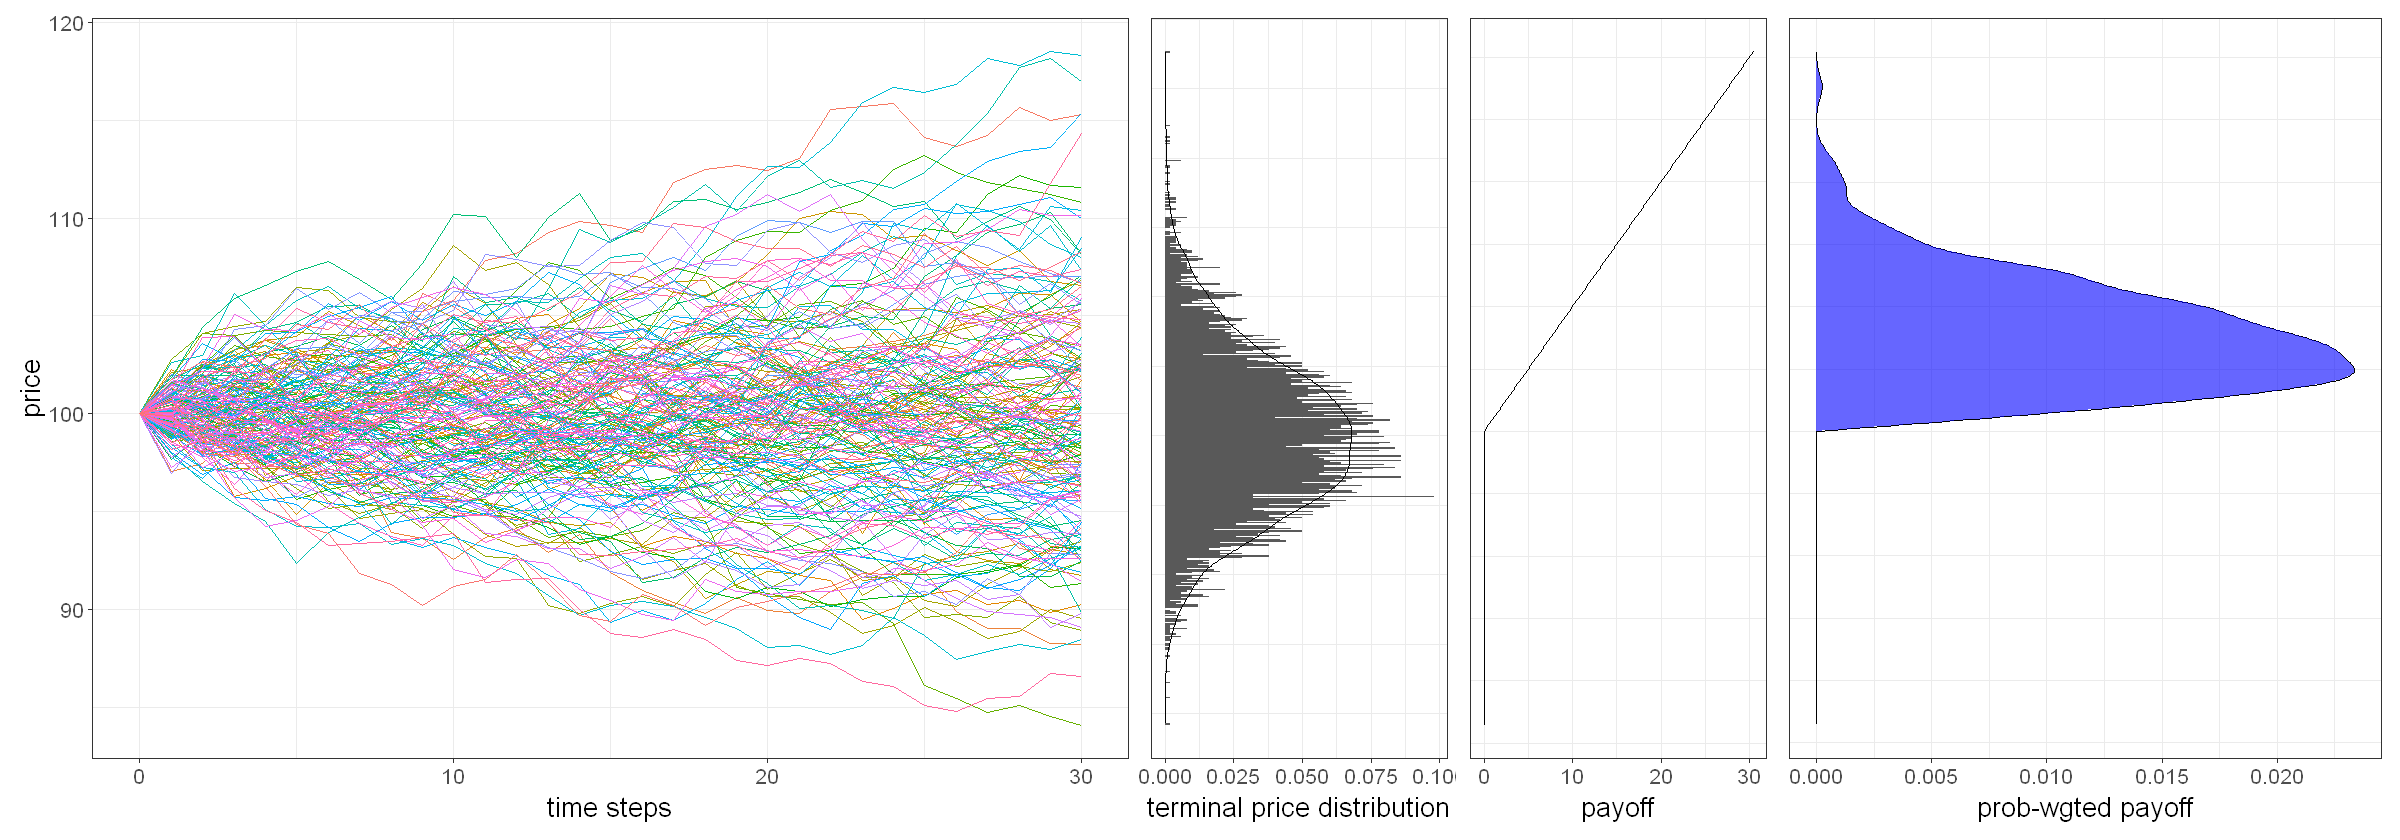

In [167]:
time_to_expiry <- 30
strike <- 100
S0 <- 100

baseline <- gbm_sim(nsim = 5000, t = time_to_expiry, mu = 0, sigma = 0.2, S0 = S0, dt = 1./365) 
option_valuation_plot(baseline, strike = strike, time_to_expiry = 30, option_type = 'call')

In [168]:
baseline %>% 
  expected_value(time_to_expiry = time_to_expiry, strike = strike) %>% 
  pull(ev) %>% 
  round(2)

[1] 2.34

### Effect of increasing intrinsic value

The intrinsic value of a call option is simply the difference between the current price of the underlying asset and the price of the option you are long.

So the intrinsic value of the stock will increase as the stock price increases above $100.

Let’s visualise this effect. Let’s assume everything is the same as before, except that the underlying asset price is $105 ($5 above the strike price of our call option.) In this case the intrinsic value of the option is $5 because we can buy it $5 cheaper by exercising the option than we can sell it on the exchange.

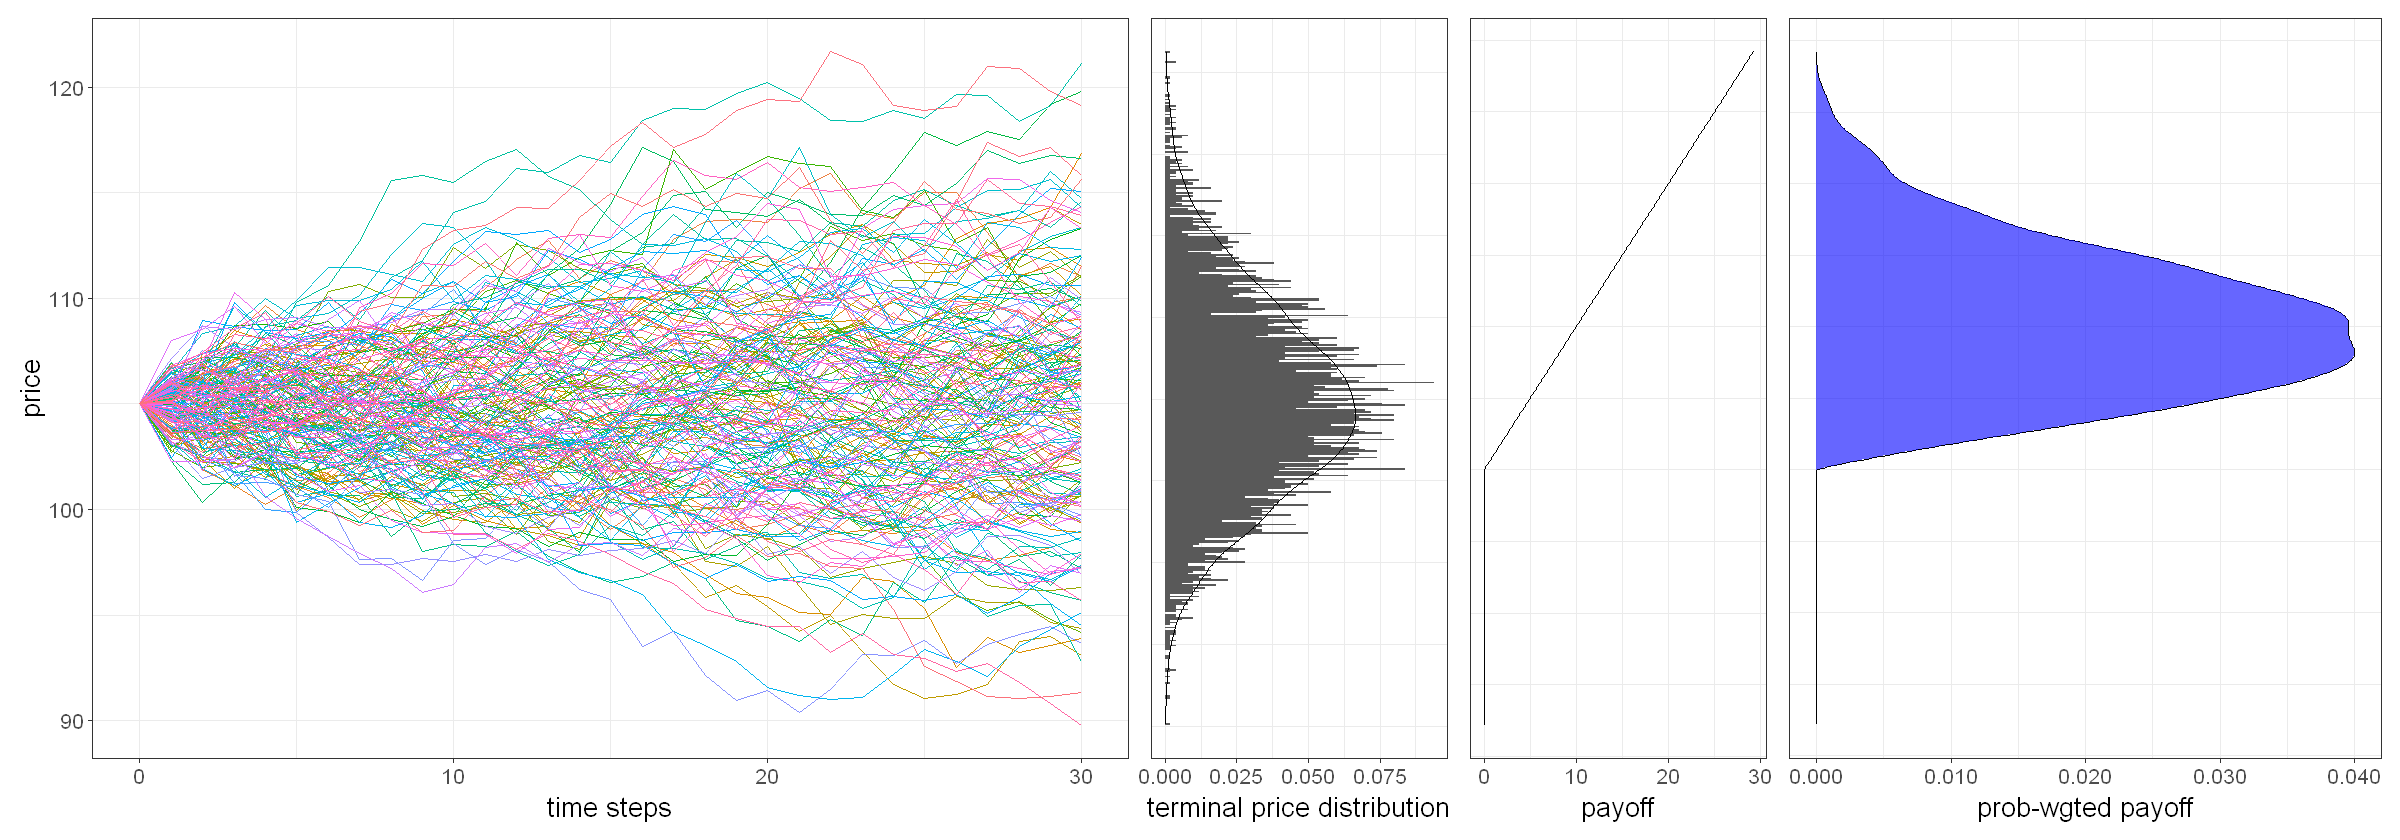

In [169]:
time_to_expiry <- 30
strike <- 100
S0 <- 105

inc_intrinsic <- gbm_sim(nsim = 5000, t = time_to_expiry, mu = 0, sigma = 0.2, S0 = S0, dt = 1./365) 
option_valuation_plot(inc_intrinsic, strike = strike, time_to_expiry = 30, option_type = 'call')

In [170]:
inc_intrinsic %>% 
  expected_value(time_to_expiry = time_to_expiry, strike = strike) %>% 
  pull(ev) %>% 
  round(2)

[1] 5.66

There are 30 days to expiry, and the path of the underlying asset is uncertain, so there is a range of possible payoff scenarios, including unprofitable ones. But it is clear that there is more probability mass in the price range in which our option has a positive payoff and less in the range which it is worthless. There is also a relatively higher chance of very high returns.

Thus, we can see how the value of the call option increases as the value of the stock increases, all other things being equal.

### Effect of increasing price uncertainty

It is intuitively obvious that options are valuable because asset prices are uncertain.

Our call option payoff profile has a kink in it, which means that our downside is limited but our upside is unlimited.

So, if the uncertainty around the asset price at expiration payoff increases, that means that we are more likely to experience very high positive payoffs, but the size of our negative payoffs are all capped at the price we paid for the option.

Let’s visualise this effect. Again we’ll assume everything is the same as before, except that the volatility of the asset has doubled to 40%.

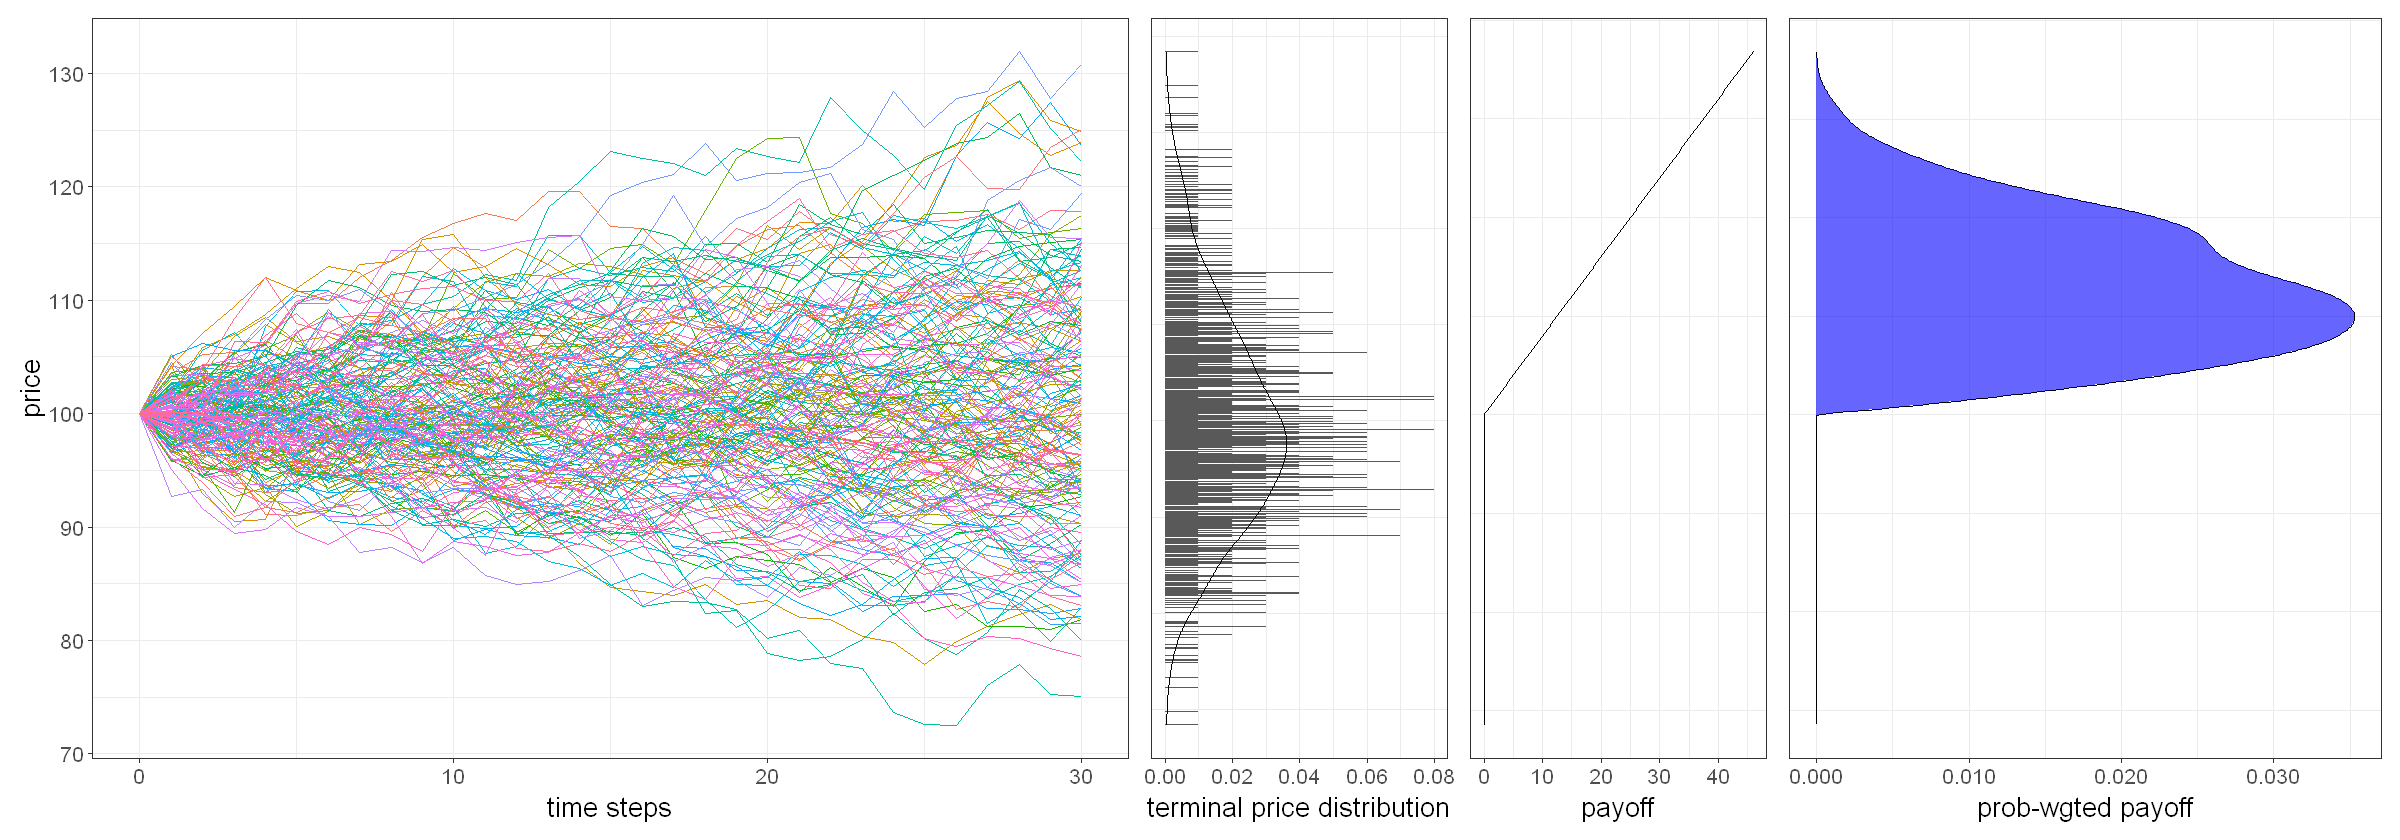

In [171]:
time_to_expiry <- 30
strike <- 100
S0 <- 100
sigma = 0.4

inc_vol <- gbm_sim(nsim = 1000, t = time_to_expiry, mu = 0, sigma = sigma, S0 = S0, dt = 1./365) 
option_valuation_plot(inc_vol, strike = strike, time_to_expiry = 30, option_type = 'call')

In [172]:
inc_vol %>% 
  expected_value(time_to_expiry = time_to_expiry, strike = strike) %>% 
  pull(ev) %>% 
  round(2)

[1] 4.73

You can see that we now have a higher probability of more extreme prices. We have more probability mass over very high payoffs. But the payoff on the downside is flat. The option expires worthless however far under $100 the price of the asset goes.

So the payoff profile of the option means we are positively exposed to upside volatility without being negatively exposed to downside volatility.

Thus, we can see how the value of the call option price increases as the volatility of the asset increases, all else being equal.

### How long does the option last?

We’ve just seen that an option has value because of its kinky payoff profile and the uncertainty in the price at expiry.

As time passes, there is less time for the asset price to move a long way. Thus, time passing acts in a very similar manner to lower volatility. It compresses the probability distribution of prices at expiration, such that there is less chance of extreme prices.

All things being equal, time passing makes the option less valuable.

Let’s visualise this. Again, we’ll assume that everything is the same as before, except that now we’ve only got 10 days to expiration.

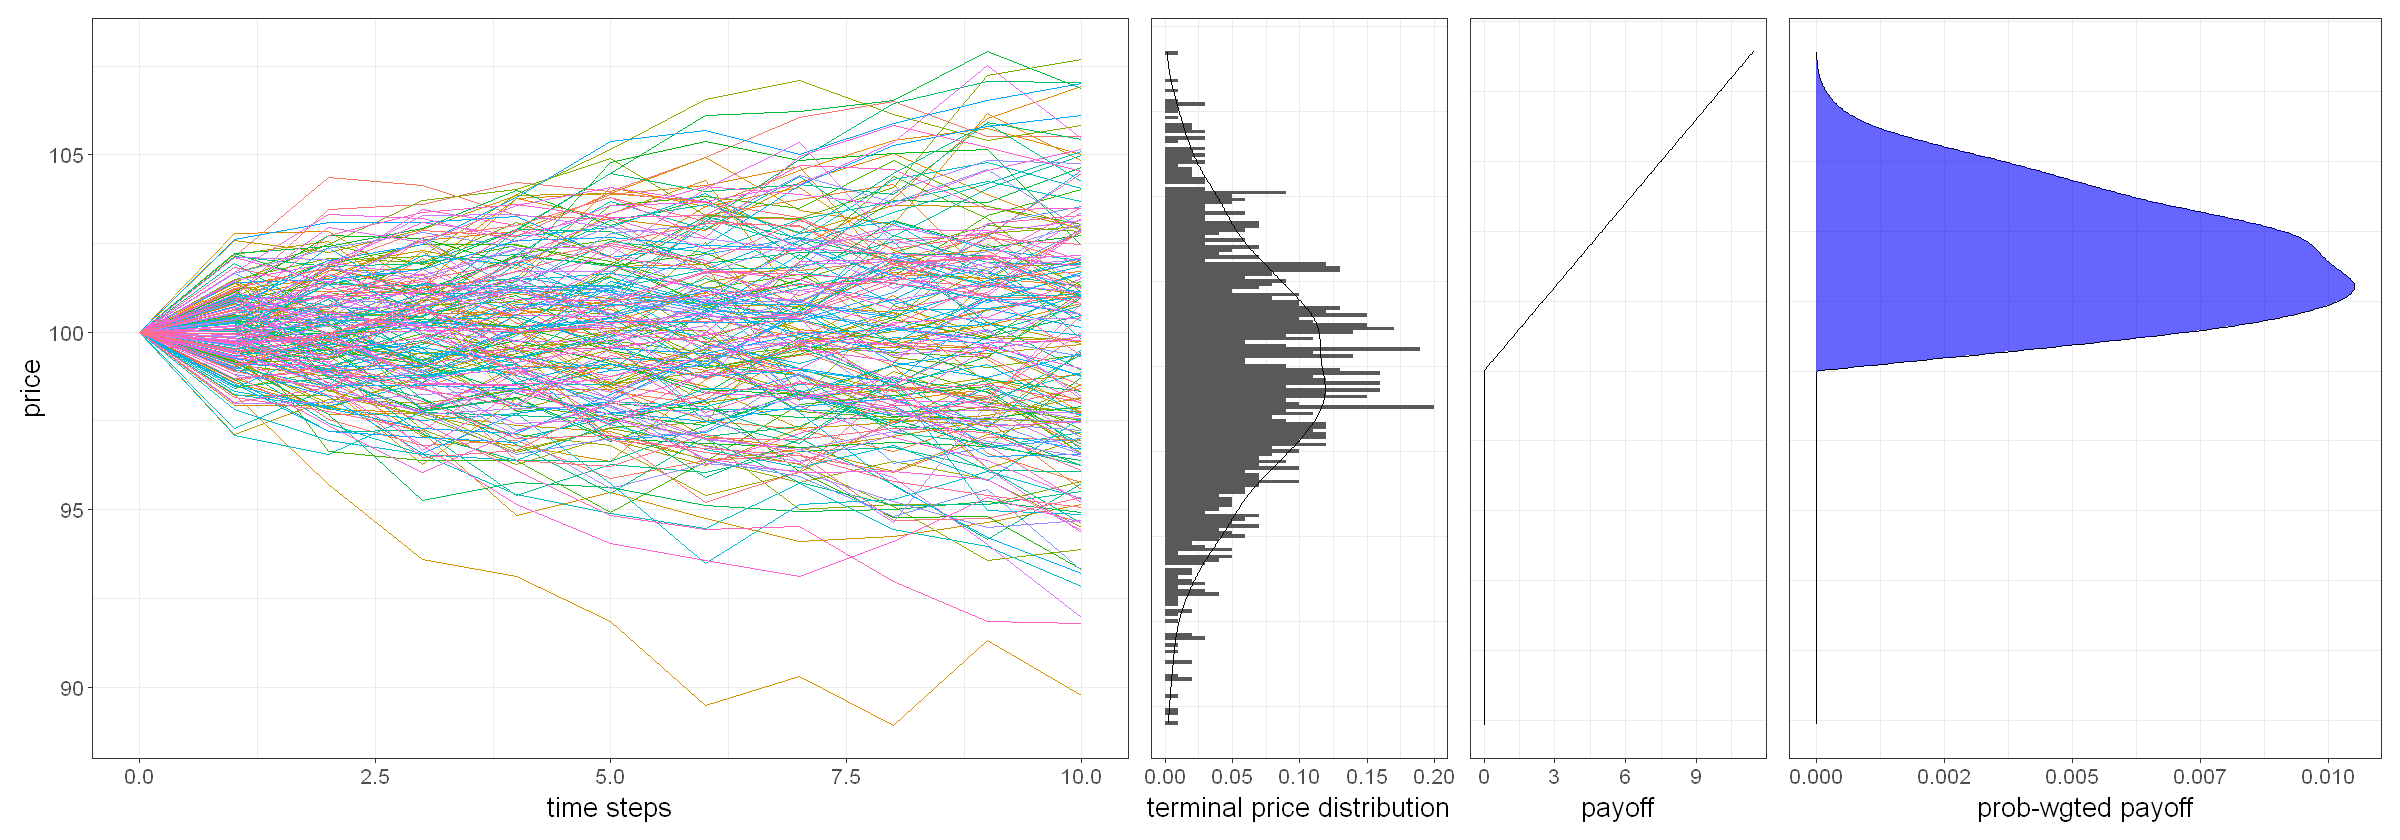

In [173]:
time_to_expiry <- 10
strike <- 100
S0 <- 100
sigma = 0.2

dec_time <- gbm_sim(nsim = 1000, t = time_to_expiry, mu = 0, sigma = sigma, S0 = S0, dt = 1./365) 
option_valuation_plot(dec_time, strike = strike, time_to_expiry = time_to_expiry, option_type = 'call')

In [174]:
dec_time %>% 
  expected_value(time_to_expiry = time_to_expiry, strike = strike) %>% 
  pull(ev) %>% 
  round(2)

[1] 1.27

You can see we now have a significantly lower probability of extremely high prices. There’s less probability mass at prices with very high payoffs, so the option is worth less.

Thus, we can see how the value of the call option decreases as time passes, all else being equal.

## Summary

Options are valuable because they allow us to take advantage of the uncertainty in future asset prices in a non-linear way.

To understand the value of an option you only really need to understand two things:

- the possible payoffs of the option at expiration (which are simply a function of the strike price of the option contract)
- the probability distribution of prices at expiration.

That’s all you need to build your intuition about options. Get used to thinking about options in terms of the interaction of the probability distribution of the underlying price at expiration, and the payoff profile. 

*The value of an option is simply the sum of the product of those two things: the sum of all the probability-weighted payoffs.*